<a href="https://colab.research.google.com/github/molotovsingh/L1/blob/main/Multi_Index_Normalised_Momentum_Score.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Stock Portfolio Rebalancing Script

## Overview
This notebook is designed to assist with the monthly rebalancing of a stock portfolio based on cross-sectional momentum. It identifies the top 30 stocks based on their Normalized Momentum Score (NMS) and calculates the appropriate weights for investment.

## What is Cross-Sectional Momentum?
Cross-sectional momentum is an investment strategy that focuses on buying securities that have had higher returns relative to other securities in the market over a specific past period, and selling those that have had poor returns. This strategy assumes that stocks which performed well in the recent past will continue to perform well in the short-term future, and vice versa for poorly performing stocks.

### Key Components of Cross-Sectional Momentum:
- **Relative Performance**: Unlike absolute momentum which looks at a security's own past return, cross-sectional momentum compares the performance of many securities against each other.
- **Selection Criterion**: Stocks are ranked based on their past returns, adjusted for volatility, known as the Normalized Momentum Score (NMS).
- **Rebalancing**: Frequent rebalancing is essential, typically at regular intervals such as monthly or quarterly, to adjust positions according to the latest data.

## Strategy
- **Entry Strategy**: On the first trading day of each month, enter positions in the top 30 stocks identified by the script. These stocks represent the highest ranking in terms of cross-sectional momentum.
- **Rebalancing Strategy**: At the end of the month, run this script again to re-evaluate and adjust the allocations according to the new weights calculated. This helps in capturing the momentum shifts among the stocks.

## Instructions for Use
1. **Run the Script**: Execute this notebook on the first trading day of each month. The script will fetch current stock data, calculate their NMS, and determine the top 30 stocks along with their investment weights.
2. **Allocate Capital**: Based on the output weights, allocate your capital accordingly among the top 30 stocks.
3. **Rebalancing**:
   - At the end of the month, re-run the notebook.
   - Adjust your positions according to the new weights. This involves buying stocks that have moved into the top 30 and selling those that have dropped out or declined in rank.
   
## Note on Data:
The stock data is fetched using the `yfinance` library, which pulls live market data. Ensure you have a stable internet connection when running this script.

## Disclaimer:
This tool is provided for informational purposes only. Always consult with a financial advisor before making investment decisions. Past performance is not indicative of future results.


In [ ]:
#Version 2 uses finhub



In [ ]:
pip install finnhub-python

Processing tickers:   0%|          | 0/503 [00:00<?, ?it/s]

Execution time: 11.00 seconds
Results saved in: /content/Results/finnhub_top_30_stocks_weights.csv
Results saved in: ./Results/finnhub_all_tickers_nms_rank.csv
Top 30 stocks weights saved in: /content/Results/finhub_top_30_stocks_weights.csv
Results saved in: /content/Results/finnhub_top_30_stocks_weights.csv


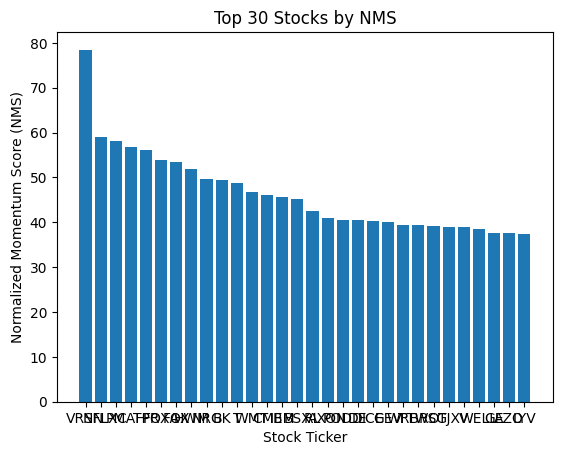

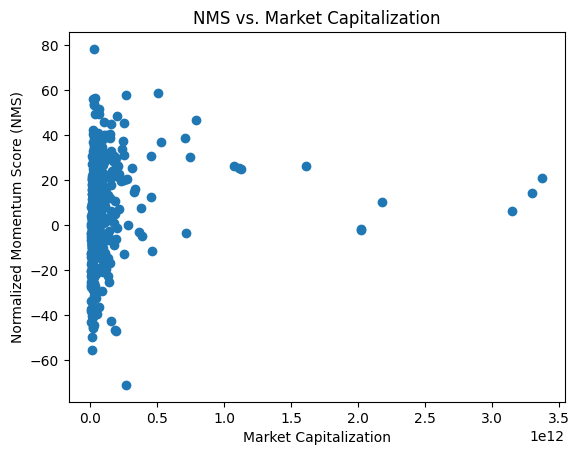

/content/Results/finnhub_all_tickers_nms_rank.csv
/content/Results/finhub_top_30_stocks_weights.csv


In [ ]:
# Install required packages
#pip install finnhub-python

# Import necessary libraries
import finnhub
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import os
from joblib import Memory
import time
import logging
from tqdm.notebook import tqdm
from concurrent.futures import ThreadPoolExecutor
import matplotlib.pyplot as plt
from IPython.display import FileLink

# Setup FinnHub API
finnhub_client = finnhub.Client(api_key='cfqimlhr01qigsfjt6g0cfqimlhr01qigsfjt6gg')

# Constants
CACHE_DIR_BASE = './cache'
LOG_FILE = './stock_analysis.log'
RESULT_DIR = './Results'
DAYS_HISTORY = 400
MAX_WORKERS = 10
RETRY_ATTEMPTS = 3


# Ensure directories are set up
os.makedirs(CACHE_DIR_BASE, exist_ok=True)
os.makedirs(RESULT_DIR, exist_ok=True)

# Setup logging
logging.basicConfig(filename=LOG_FILE, level=logging.INFO, format='%(asctime)s:%(levelname)s:%(message)s', force=True)

# Setup a cache directory for each ticker, allowing for more granular caching
def setup_memory_cache(ticker):
    cachedir = f'{CACHE_DIR_BASE}/{ticker}'
    memory = Memory(cachedir, verbose=0, compress=True)
    return memory

# Function to download data using FinnHub
def download_data(ticker, start_date, end_date, memory):
    @memory.cache
    def fetch_data():
        start_timestamp = int(start_date.timestamp())
        end_timestamp = int(end_date.timestamp())
        res = finnhub_client.stock_candles(ticker, 'D', start_timestamp, end_timestamp)
        if res['s'] == 'ok':
            df = pd.DataFrame(res)
            df['t'] = pd.to_datetime(df['t'], unit='s')
            df.set_index('t', inplace=True)
            return df[['c', 'h', 'l', 'o', 'v']]
        return pd.DataFrame()
    return fetch_data()

# Function to fetch stock data with retries and error handling
def fetch_data_with_retry(ticker, start_date, end_date, attempts=RETRY_ATTEMPTS):
    memory = setup_memory_cache(ticker)
    for i in range(attempts):
        try:
            data = download_data(ticker, start_date, end_date, memory)
            if not data.empty:
                return data
        except Exception as e:
            logging.error(f"Attempt {i + 1} for {ticker} failed: {e}")
            time.sleep(2 ** i)  # Exponential backoff
    logging.error(f"Failed to fetch data for {ticker} after {attempts} attempts.")
    return None

# Define the date range for the data fetch
end_date = datetime.now()
start_date = end_date - timedelta(days=DAYS_HISTORY)

# Define ticker symbols
tickers = ["MSFT", "AAPL", "NVDA", "GOOGL", "GOOG", "AMZN", "META", "BRK-B", "LLY", "AVGO",
    "JPM", "TSLA", "V", "WMT", "XOM", "UNH", "MA", "PG", "COST", "JNJ", "ORCL", "MRK",
    "HD", "BAC", "CVX", "NFLX", "ABBV", "AMD", "KO", "CRM", "PEP", "QCOM", "TMO", "ADBE",
    "WFC", "LIN", "DHR", "TMUS", "ACN", "CSCO", "MCD", "DIS", "AMAT", "GE", "TXN", "ABT",
    "AXP", "CAT", "INTU", "VZ", "AMGN", "PFE", "MS", "NEE", "IBM", "PM", "NOW", "CMCSA",
    "BX", "GS", "ISRG", "MU", "UNP", "RTX", "NKE", "COP", "SPGI", "ETN", "UBER", "INTC",
    "HON", "BKNG", "SCHW", "SYK", "LRCX", "T", "LOW", "C", "ELV", "PGR", "UPS", "VRTX",
    "BLK", "TJX", "ADI", "LMT", "BSX", "MDT", "CB", "BA", "REGN", "KLAC", "DE", "PANW",
    "MMC", "ADP", "PLD", "ANET", "CI", "ABNB", "MDLZ", "SNPS", "SBUX", "FI", "AMT", "CMG",
    "SO", "WM", "BMY", "HCA", "GD", "GILD", "APH", "CDNS", "DUK", "ICE", "MO", "ZTS",
    "CME", "SHW", "CL", "TT", "TDG", "MCO", "FCX", "MCK", "EQIX", "CEG", "ITW", "NXPI",
    "EOG", "CVS", "CTAS", "NOC", "PH", "MAR", "TGT", "ECL", "BDX", "SLB", "CSX", "EMR",
    "PYPL", "MRNA", "USB", "MPC", "PNC", "AON", "FDX", "MSI", "PSX", "WELL", "CARR", "RSG",
    "APD", "ROP", "ORLY", "PCAR", "MMM", "AJG", "OXY", "MNST", "VLO", "MCHP", "EW", "COF",
    "CPRT", "AIG", "SMCI", "MET", "TFC", "NSC", "HLT", "DXCM", "GM", "AFL", "JCI", "WMB",
    "TRV", "GEV", "NEM", "AZO", "SPG", "SRE", "PSA", "F", "ROST", "DHI", "GWW", "OKE",
    "AEP", "FTNT", "HES", "KDP", "ADSK", "TEL", "DLR", "STZ", "O", "EL", "URI", "PAYX",
    "KMB", "D", "BK", "A", "AMP", "COR", "KHC", "ALL", "FIS", "LEN", "PRU", "IDXX", "CCI",
    "LHX", "KMI", "HUM", "IQV", "PWR", "NUE", "DOW", "AME", "HSY", "CNC", "PCG", "OTIS",
    "CHTR", "MSCI", "CMI", "ACGL", "YUM", "CTVA", "GIS", "KR", "IR", "RCL", "FAST", "ODFL",
    "PEG", "KVUE", "EXC", "MPWR", "LULU", "GEHC", "SYY", "EA", "VRSK", "NDAQ", "MLM", "VST",
    "CSGP", "XYL", "HWM", "FANG", "VMC", "FICO", "IT", "CTSH", "DD", "DAL", "LVS", "ED",
    "BKR", "LYB", "HPQ", "HAL", "DG", "BIIB", "MTD", "GRMN", "RMD", "ON", "GLW", "CDW",
    "DFS", "PPG", "DVN", "TSCO", "EXR", "ROK", "HIG", "WAB", "ADM", "XEL", "EFX", "FSLR",
    "VICI", "ANSS", "EIX", "AVB", "EBAY", "CBRE", "FTV", "DECK", "TTWO", "TROW", "GPN",
    "RJF", "CHD", "WTW", "BRO", "WEC", "FITB", "TRGP", "DOV", "VLTO", "DLTR", "KEYS",
    "MTB", "AWK", "EQR", "IFF", "WDC", "WST", "PHM", "ZBH", "HPE", "NTAP", "BR", "IRM",
    "CAH", "DTE", "ETR", "NVR", "STT", "STE", "TER", "APTV", "FE", "ROL", "HUBB", "LYV",
    "WY", "PTC", "BF.B", "AXON", "BALL", "PPL", "INVH", "STLD", "TYL", "BLDR", "K", "TSN",
    "ARE", "LDOS", "WRB", "ES", "GPC", "SBAC", "CTRA", "WAT", "HBAN", "STX", "MOH", "MKC",
    "PFG", "ALGN", "HRL", "VTR", "CBOE", "TDY", "CCL", "AEE", "WBD", "CNP", "COO", "CPAY",
    "OMC", "CINF", "CMS", "ULTA", "AVY", "NRG", "EQT", "DRI", "J", "DPZ", "RF", "SYF",
    "BAX", "HOLX", "VRSN", "NTRS", "ENPH", "EG", "UAL", "ATO", "ILMN", "TXT", "LH", "ZBRA",
    "CE", "EXPD", "ESS", "FDS", "L", "PKG", "CLX", "IEX", "JBHT", "CFG", "LUV", "IP", "DGX",
    "GEN", "MAA", "BBY", "NWSA", "NWS", "MAS", "FOXA", "FOX", "ALB", "AES", "SWKS", "BG",
    "CAG", "JBL", "MRO", "AMCR", "AKAM", "SNA", "CF", "EXPE", "RVTY", "WRK", "POOL", "TRMB",
    "WBA", "PNR", "KEY", "NDSN", "CPB", "DOC", "SWK", "HST", "INCY", "LW", "UDR", "LNT",
    "TECH", "PODD", "NI", "MGM", "KIM", "AOS", "VTRS", "JKHY", "EVRG", "BEN", "DVA", "IPG",
    "EMN", "SJM", "LKQ", "JNPR", "CRL", "RL", "CPT", "KMX", "REG", "APA", "BBWI", "ALLE",
    "WYNN", "TAP", "UHS", "EPAM", "SOLV", "CHRW", "HII", "MOS", "FFIV", "CTLT", "PAYC",
    "TFX", "TPR", "QRVO", "BXP", "HSIC", "AAL", "GNRC", "DAY", "AIZ", "PNW", "HAS", "PARA",
    "BIO", "MKTX", "FRT", "BWA", "MTCH", "FMC", "GL", "MHK", "CZR", "ETSY", "IVZ", "RHI",
    "NCLH", "CMA"]

# Initialize DataFrame for metrics
df = pd.DataFrame(index=tickers, columns=['1Month Log Returns', '6Month Log Returns', '1Year Log Returns', 'NMS', 'Market Capitalisation'])

# Set display options for better readability
pd.set_option('display.float_format', '{:,.2f}'.format)

# Start the execution timer
start_time = time.time()

# Parallel processing of tickers
def process_ticker(ticker):
    data = fetch_data_with_retry(ticker, start_date, end_date)
    if data is not None and not data.empty:
        close_prices = data['c']
        df.loc[ticker, '1Month Log Returns'] = np.log(close_prices.iloc[-1] / close_prices.iloc[-22]) if len(close_prices) > 22 else np.nan
        df.loc[ticker, '6Month Log Returns'] = np.log(close_prices.iloc[-1] / close_prices.iloc[-126]) if len(close_prices) > 126 else np.nan
        df.loc[ticker, '1Year Log Returns'] = np.log(close_prices.iloc[-1] / close_prices.iloc[-252]) if len(close_prices) > 252 else np.nan
        daily_log_returns = np.log(close_prices / close_prices.shift(1))
        volatility = daily_log_returns.std()
        df.loc[ticker, 'NMS'] = (df.loc[ticker, '1Month Log Returns'] + df.loc[ticker, '6Month Log Returns'] + df.loc[ticker, '1Year Log Returns']) / volatility if volatility > 0 else np.nan
        market_cap = finnhub_client.company_profile2(symbol=ticker).get('marketCapitalization', np.nan)
        if market_cap:
            df.loc[ticker, 'Market Capitalisation'] = float(market_cap) * 1e6  # Ensure it's in the correct scale
        else:
            logging.warning(f"No market capitalization data for {ticker}")

# Execute processing in parallel and track progress
with ThreadPoolExecutor(max_workers=MAX_WORKERS) as executor:
    list(tqdm(executor.map(process_ticker, tickers), total=len(tickers), desc="Processing tickers"))

# Calculate and print execution time
execution_time = time.time() - start_time
print(f"Execution time: {execution_time:.2f} seconds")

# Ranking and saving results
df['Rank'] = df['NMS'].rank(ascending=False, method='min')
all_ranks_output_path = os.path.join(RESULT_DIR, 'finnhub_all_tickers_nms_rank.csv')
df[['NMS', 'Rank']].to_csv(all_ranks_output_path)

'''
# Handle weighting for top 30 stocks
top_30_stocks = df.sort_values(by='NMS', ascending=False).head(30)
top_30_stocks['Tilted Weight'] = top_30_stocks['Market Capitalisation'] * top_30_stocks['NMS']
total_tilted_weight = top_30_stocks['Tilted Weight'].sum()

if total_tilted_weight > 0:
    top_30_stocks['Tilted Weight'] /= total_tilted_weight
    top_30_stocks['Capped Weight'] = top_30_stocks['Tilted Weight'].apply(lambda x: min(x, 0.05))
    top_30_stocks['Final Weight'] = top_30_stocks['Capped Weight'] / top_30_stocks['Capped Weight'].sum()
else:
    logging.error("Total tilted weight is zero, indicating no valid data was processed for weight calculations.")

top_30_output_path = os.path.join(RESULT_DIR, 'finnhub_top_30_stocks_weights.csv')
top_30_stocks.to_csv(top_30_output_path)

print(f"Results saved in: {all_ranks_output_path}")
print(f"Top 30 stocks weights saved in: {top_30_output_path}")
'''

# Assuming df is the DataFrame with the initial data
top_30_stocks = df.sort_values(by='NMS', ascending=False).head(30)
top_30_stocks['Tilted Weight'] = top_30_stocks['Market Capitalisation'] * top_30_stocks['NMS']
total_tilted_weight = top_30_stocks['Tilted Weight'].sum()
top_30_stocks['Tilted Weight'] /= total_tilted_weight

if total_tilted_weight > 0:
    # Cap the initial weights at 5%
    top_30_stocks['Capped Weight'] = top_30_stocks['Tilted Weight'].apply(lambda x: min(x, 0.05))

    while True:
        total_capped_weight = top_30_stocks['Capped Weight'].sum()
        # Normalize the capped weights
        top_30_stocks['Final Weight'] = top_30_stocks['Capped Weight'] / total_capped_weight

        # Check if any weight still exceeds 5%
        over_capped = top_30_stocks['Final Weight'] > 0.05
        if not over_capped.any():
            break

        # Reduce weights that are over 5% and redistribute the excess
        excess_weight = (top_30_stocks['Final Weight'][over_capped] - 0.05).sum()
        top_30_stocks.loc[over_capped, 'Capped Weight'] = 0.05
        top_30_stocks.loc[~over_capped, 'Capped Weight'] += (top_30_stocks['Capped Weight'][~over_capped] / top_30_stocks['Capped Weight'][~over_capped].sum()) * excess_weight

else:
    logging.error("Total tilted weight is zero, indicating no valid data was processed for weight calculations.")

# Specify the path in your Google Drive
RESULT_DIR = '/content/Results'
output_path = os.path.join(RESULT_DIR, 'finnhub_top_30_stocks_weights.csv')
top_30_stocks.to_csv(output_path)

print(f"Results saved in: {output_path}")


# Output the results
top_30_output_path = os.path.join(RESULT_DIR, 'finhub_top_30_stocks_weights.csv') #/content/Results
top_30_stocks.to_csv(top_30_output_path)
print(f"Results saved in: {all_ranks_output_path}")
print(f"Top 30 stocks weights saved in: {top_30_output_path}")

#RESULT_DIR
#RESULT_DIR = os.path.join(RESULT_DIR, 'finnhub_top_30_stocks_weights.csv')
#output_path = os.path.join(RESULT_DIR, 'finnhub_top_30_stocks_weights.csv')
#top_30_stocks.to_csv(output_path)

print(f"Results saved in: {output_path}")


# Visualization of top 30 stocks by NMS
plt.bar(top_30_stocks.index, top_30_stocks['NMS'])
plt.xlabel('Stock Ticker')
plt.ylabel('Normalized Momentum Score (NMS)')
plt.title('Top 30 Stocks by NMS')
plt.show()

# Visualization of NMS vs. Market Capitalization
plt.scatter(df['Market Capitalisation'], df['NMS'])
plt.xlabel('Market Capitalization')
plt.ylabel('Normalized Momentum Score (NMS)')
plt.title('NMS vs. Market Capitalization')
plt.show()

# Display download link for the results
print(FileLink(all_ranks_output_path))
print(FileLink(top_30_output_path))


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Processing tickers:   0%|          | 0/503 [00:00<?, ?it/s]

Execution time: 8.13 seconds
All ranks saved in: ./Results/finnhub_all_tickers_nms_rank.csv
Top 30 stocks weights saved in: ./Results/finnhub_top_30_stocks_weights.csv


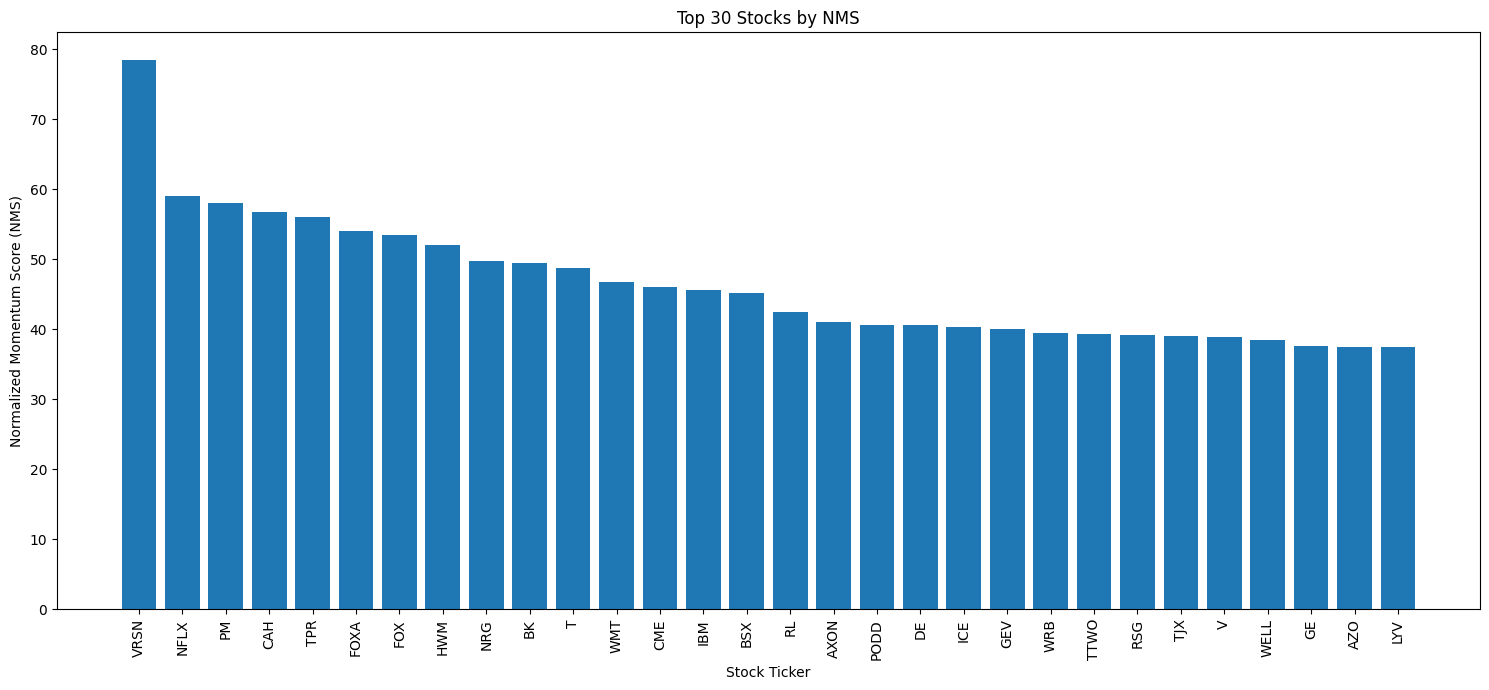

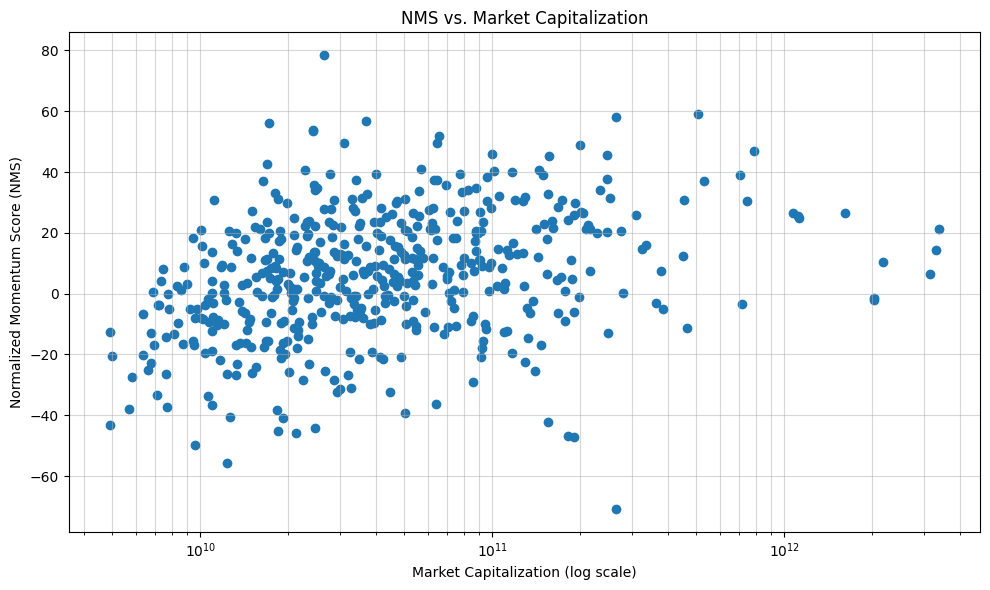

All ranks CSV:
/content/Results/finnhub_all_tickers_nms_rank.csv

Top 30 stocks weights CSV:
/content/Results/finnhub_top_30_stocks_weights.csv


In [ ]:
# Install required packages
#pip install finnhub-python

# Import necessary libraries
import finnhub
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import os
from joblib import Memory
import time
import logging
from tqdm.notebook import tqdm
from concurrent.futures import ThreadPoolExecutor
import matplotlib.pyplot as plt
from IPython.display import FileLink
from google.colab import userdata # <<< ADD THIS LINE

# Setup FinnHub API
# finnhub_client = finnhub.Client(api_key='cfqimlhr01qigsfjt6g0cfqimlhr01qigsfjt6gg') # <<< OLD LINE

# --- START OF MODIFICATION ---
FINNHUB_API_KEY = userdata.get('finhub')
if not FINNHUB_API_KEY:
    raise ValueError("Finnhub API key not found. Please add it to Colab Secrets with the name 'finhub' and ensure notebook access is enabled.")
finnhub_client = finnhub.Client(api_key=FINNHUB_API_KEY)
# --- END OF MODIFICATION ---


# Constants
CACHE_DIR_BASE = './cache'
LOG_FILE = './stock_analysis.log'
RESULT_DIR = './Results'
DAYS_HISTORY = 400
MAX_WORKERS = 10
RETRY_ATTEMPTS = 3


# Ensure directories are set up
os.makedirs(CACHE_DIR_BASE, exist_ok=True)
os.makedirs(RESULT_DIR, exist_ok=True)

# Setup logging
logging.basicConfig(filename=LOG_FILE, level=logging.INFO, format='%(asctime)s:%(levelname)s:%(message)s', force=True)

# Setup a cache directory for each ticker, allowing for more granular caching
def setup_memory_cache(ticker):
    cachedir = f'{CACHE_DIR_BASE}/{ticker}'
    memory = Memory(cachedir, verbose=0, compress=True)
    return memory

# Function to download data using FinnHub
def download_data(ticker, start_date, end_date, memory):
    @memory.cache
    def fetch_data():
        start_timestamp = int(start_date.timestamp())
        end_timestamp = int(end_date.timestamp())
        res = finnhub_client.stock_candles(ticker, 'D', start_timestamp, end_timestamp)
        if res['s'] == 'ok':
            df = pd.DataFrame(res)
            df['t'] = pd.to_datetime(df['t'], unit='s')
            df.set_index('t', inplace=True)
            return df[['c', 'h', 'l', 'o', 'v']]
        return pd.DataFrame()
    return fetch_data()

# Function to fetch stock data with retries and error handling
def fetch_data_with_retry(ticker, start_date, end_date, attempts=RETRY_ATTEMPTS):
    memory = setup_memory_cache(ticker)
    for i in range(attempts):
        try:
            data = download_data(ticker, start_date, end_date, memory)
            if not data.empty:
                return data
        except Exception as e:
            logging.error(f"Attempt {i + 1} for {ticker} failed: {e}")
            time.sleep(2 ** i)  # Exponential backoff
    logging.error(f"Failed to fetch data for {ticker} after {attempts} attempts.")
    return None

# Define the date range for the data fetch
end_date = datetime.now()
start_date = end_date - timedelta(days=DAYS_HISTORY)

# Define ticker symbols
tickers = ["MSFT", "AAPL", "NVDA", "GOOGL", "GOOG", "AMZN", "META", "BRK-B", "LLY", "AVGO",
    "JPM", "TSLA", "V", "WMT", "XOM", "UNH", "MA", "PG", "COST", "JNJ", "ORCL", "MRK",
    "HD", "BAC", "CVX", "NFLX", "ABBV", "AMD", "KO", "CRM", "PEP", "QCOM", "TMO", "ADBE",
    "WFC", "LIN", "DHR", "TMUS", "ACN", "CSCO", "MCD", "DIS", "AMAT", "GE", "TXN", "ABT",
    "AXP", "CAT", "INTU", "VZ", "AMGN", "PFE", "MS", "NEE", "IBM", "PM", "NOW", "CMCSA",
    "BX", "GS", "ISRG", "MU", "UNP", "RTX", "NKE", "COP", "SPGI", "ETN", "UBER", "INTC",
    "HON", "BKNG", "SCHW", "SYK", "LRCX", "T", "LOW", "C", "ELV", "PGR", "UPS", "VRTX",
    "BLK", "TJX", "ADI", "LMT", "BSX", "MDT", "CB", "BA", "REGN", "KLAC", "DE", "PANW",
    "MMC", "ADP", "PLD", "ANET", "CI", "ABNB", "MDLZ", "SNPS", "SBUX", "FI", "AMT", "CMG",
    "SO", "WM", "BMY", "HCA", "GD", "GILD", "APH", "CDNS", "DUK", "ICE", "MO", "ZTS",
    "CME", "SHW", "CL", "TT", "TDG", "MCO", "FCX", "MCK", "EQIX", "CEG", "ITW", "NXPI",
    "EOG", "CVS", "CTAS", "NOC", "PH", "MAR", "TGT", "ECL", "BDX", "SLB", "CSX", "EMR",
    "PYPL", "MRNA", "USB", "MPC", "PNC", "AON", "FDX", "MSI", "PSX", "WELL", "CARR", "RSG",
    "APD", "ROP", "ORLY", "PCAR", "MMM", "AJG", "OXY", "MNST", "VLO", "MCHP", "EW", "COF",
    "CPRT", "AIG", "SMCI", "MET", "TFC", "NSC", "HLT", "DXCM", "GM", "AFL", "JCI", "WMB",
    "TRV", "GEV", "NEM", "AZO", "SPG", "SRE", "PSA", "F", "ROST", "DHI", "GWW", "OKE",
    "AEP", "FTNT", "HES", "KDP", "ADSK", "TEL", "DLR", "STZ", "O", "EL", "URI", "PAYX",
    "KMB", "D", "BK", "A", "AMP", "COR", "KHC", "ALL", "FIS", "LEN", "PRU", "IDXX", "CCI",
    "LHX", "KMI", "HUM", "IQV", "PWR", "NUE", "DOW", "AME", "HSY", "CNC", "PCG", "OTIS",
    "CHTR", "MSCI", "CMI", "ACGL", "YUM", "CTVA", "GIS", "KR", "IR", "RCL", "FAST", "ODFL",
    "PEG", "KVUE", "EXC", "MPWR", "LULU", "GEHC", "SYY", "EA", "VRSK", "NDAQ", "MLM", "VST",
    "CSGP", "XYL", "HWM", "FANG", "VMC", "FICO", "IT", "CTSH", "DD", "DAL", "LVS", "ED",
    "BKR", "LYB", "HPQ", "HAL", "DG", "BIIB", "MTD", "GRMN", "RMD", "ON", "GLW", "CDW",
    "DFS", "PPG", "DVN", "TSCO", "EXR", "ROK", "HIG", "WAB", "ADM", "XEL", "EFX", "FSLR",
    "VICI", "ANSS", "EIX", "AVB", "EBAY", "CBRE", "FTV", "DECK", "TTWO", "TROW", "GPN",
    "RJF", "CHD", "WTW", "BRO", "WEC", "FITB", "TRGP", "DOV", "VLTO", "DLTR", "KEYS",
    "MTB", "AWK", "EQR", "IFF", "WDC", "WST", "PHM", "ZBH", "HPE", "NTAP", "BR", "IRM",
    "CAH", "DTE", "ETR", "NVR", "STT", "STE", "TER", "APTV", "FE", "ROL", "HUBB", "LYV",
    "WY", "PTC", "BF.B", "AXON", "BALL", "PPL", "INVH", "STLD", "TYL", "BLDR", "K", "TSN",
    "ARE", "LDOS", "WRB", "ES", "GPC", "SBAC", "CTRA", "WAT", "HBAN", "STX", "MOH", "MKC",
    "PFG", "ALGN", "HRL", "VTR", "CBOE", "TDY", "CCL", "AEE", "WBD", "CNP", "COO", "CPAY",
    "OMC", "CINF", "CMS", "ULTA", "AVY", "NRG", "EQT", "DRI", "J", "DPZ", "RF", "SYF",
    "BAX", "HOLX", "VRSN", "NTRS", "ENPH", "EG", "UAL", "ATO", "ILMN", "TXT", "LH", "ZBRA",
    "CE", "EXPD", "ESS", "FDS", "L", "PKG", "CLX", "IEX", "JBHT", "CFG", "LUV", "IP", "DGX",
    "GEN", "MAA", "BBY", "NWSA", "NWS", "MAS", "FOXA", "FOX", "ALB", "AES", "SWKS", "BG",
    "CAG", "JBL", "MRO", "AMCR", "AKAM", "SNA", "CF", "EXPE", "RVTY", "WRK", "POOL", "TRMB",
    "WBA", "PNR", "KEY", "NDSN", "CPB", "DOC", "SWK", "HST", "INCY", "LW", "UDR", "LNT",
    "TECH", "PODD", "NI", "MGM", "KIM", "AOS", "VTRS", "JKHY", "EVRG", "BEN", "DVA", "IPG",
    "EMN", "SJM", "LKQ", "JNPR", "CRL", "RL", "CPT", "KMX", "REG", "APA", "BBWI", "ALLE",
    "WYNN", "TAP", "UHS", "EPAM", "SOLV", "CHRW", "HII", "MOS", "FFIV", "CTLT", "PAYC",
    "TFX", "TPR", "QRVO", "BXP", "HSIC", "AAL", "GNRC", "DAY", "AIZ", "PNW", "HAS", "PARA",
    "BIO", "MKTX", "FRT", "BWA", "MTCH", "FMC", "GL", "MHK", "CZR", "ETSY", "IVZ", "RHI",
    "NCLH", "CMA"]

# Initialize DataFrame for metrics
df = pd.DataFrame(index=tickers, columns=['1Month Log Returns', '6Month Log Returns', '1Year Log Returns', 'NMS', 'Market Capitalisation'])

# Set display options for better readability
pd.set_option('display.float_format', '{:,.2f}'.format)

# Start the execution timer
start_time = time.time()

# Parallel processing of tickers
def process_ticker(ticker):
    data = fetch_data_with_retry(ticker, start_date, end_date)
    if data is not None and not data.empty:
        close_prices = data['c']
        df.loc[ticker, '1Month Log Returns'] = np.log(close_prices.iloc[-1] / close_prices.iloc[-22]) if len(close_prices) > 22 else np.nan
        df.loc[ticker, '6Month Log Returns'] = np.log(close_prices.iloc[-1] / close_prices.iloc[-126]) if len(close_prices) > 126 else np.nan
        df.loc[ticker, '1Year Log Returns'] = np.log(close_prices.iloc[-1] / close_prices.iloc[-252]) if len(close_prices) > 252 else np.nan
        daily_log_returns = np.log(close_prices / close_prices.shift(1))
        volatility = daily_log_returns.std()
        df.loc[ticker, 'NMS'] = (df.loc[ticker, '1Month Log Returns'] + df.loc[ticker, '6Month Log Returns'] + df.loc[ticker, '1Year Log Returns']) / volatility if volatility > 0 else np.nan

        # Retry mechanism for company profile fetch can also be added if needed
        try:
            profile = finnhub_client.company_profile2(symbol=ticker)
            market_cap = profile.get('marketCapitalization', np.nan)
            if market_cap:
                df.loc[ticker, 'Market Capitalisation'] = float(market_cap) * 1e6  # Ensure it's in the correct scale
            else:
                logging.warning(f"No market capitalization data for {ticker} from profile: {profile}")
        except Exception as e:
            logging.error(f"Failed to fetch company profile for {ticker}: {e}")
            df.loc[ticker, 'Market Capitalisation'] = np.nan


# Execute processing in parallel and track progress
with ThreadPoolExecutor(max_workers=MAX_WORKERS) as executor:
    list(tqdm(executor.map(process_ticker, tickers), total=len(tickers), desc="Processing tickers"))

# Calculate and print execution time
execution_time = time.time() - start_time
print(f"Execution time: {execution_time:.2f} seconds")

# Ranking and saving results
df['Rank'] = df['NMS'].rank(ascending=False, method='min')
all_ranks_output_path = os.path.join(RESULT_DIR, 'finnhub_all_tickers_nms_rank.csv')
df[['NMS', 'Rank']].to_csv(all_ranks_output_path)


# Assuming df is the DataFrame with the initial data
top_30_stocks = df.sort_values(by='NMS', ascending=False).head(30).copy() # Use .copy() to avoid SettingWithCopyWarning

# Ensure 'Market Capitalisation' and 'NMS' are numeric, coercing errors if necessary
top_30_stocks['Market Capitalisation'] = pd.to_numeric(top_30_stocks['Market Capitalisation'], errors='coerce')
top_30_stocks['NMS'] = pd.to_numeric(top_30_stocks['NMS'], errors='coerce')

# Drop rows where necessary data for weighting is missing
top_30_stocks.dropna(subset=['Market Capitalisation', 'NMS'], inplace=True)


if not top_30_stocks.empty:
    top_30_stocks.loc[:, 'Tilted Weight'] = top_30_stocks['Market Capitalisation'] * top_30_stocks['NMS']
    total_tilted_weight = top_30_stocks['Tilted Weight'].sum()

    if total_tilted_weight > 0:
        top_30_stocks.loc[:, 'Tilted Weight'] = top_30_stocks['Tilted Weight'] / total_tilted_weight
        # Cap the initial weights at 5%
        top_30_stocks.loc[:, 'Capped Weight'] = top_30_stocks['Tilted Weight'].apply(lambda x: min(x, 0.05))

        # Iteratively adjust weights
        iteration_count = 0
        max_iterations = 20 # Safety break for the loop
        while iteration_count < max_iterations:
            iteration_count += 1
            total_capped_weight = top_30_stocks['Capped Weight'].sum()
            if total_capped_weight == 0: # Avoid division by zero
                logging.warning("Total capped weight is zero during normalization, cannot proceed with weighting.")
                top_30_stocks.loc[:, 'Final Weight'] = 0
                break

            top_30_stocks.loc[:, 'Final Weight'] = top_30_stocks['Capped Weight'] / total_capped_weight

            over_capped_mask = top_30_stocks['Final Weight'] > 0.05000000001 # Add small epsilon for float comparisons
            if not over_capped_mask.any():
                break # All weights are capped correctly

            excess_weight_sum = (top_30_stocks.loc[over_capped_mask, 'Final Weight'] - 0.05).sum()
            top_30_stocks.loc[over_capped_mask, 'Capped Weight'] = 0.05 # Set capped weights to 0.05

            # Redistribute excess to non-capped stocks proportionally to their current Capped Weights
            non_capped_mask = ~over_capped_mask
            sum_non_capped_weights = top_30_stocks.loc[non_capped_mask, 'Capped Weight'].sum()

            if sum_non_capped_weights > 0: # Check if there are non-capped stocks to redistribute to
                redistribution_factor = top_30_stocks.loc[non_capped_mask, 'Capped Weight'] / sum_non_capped_weights
                top_30_stocks.loc[non_capped_mask, 'Capped Weight'] += redistribution_factor * excess_weight_sum
            elif excess_weight_sum > 0 : # Excess weight exists but no stocks to redistribute to implies an issue
                logging.warning("Excess weight could not be redistributed as no non-capped stocks are available with positive weights.")
                # This scenario might indicate all stocks are capped, or weights are extremely skewed.
                # Forcing normalization of what's currently capped:
                current_sum_of_capped_weights = top_30_stocks['Capped Weight'].sum()
                if current_sum_of_capped_weights > 0:
                     top_30_stocks.loc[:, 'Capped Weight'] = top_30_stocks['Capped Weight'] / current_sum_of_capped_weights * (1 - (over_capped_mask.sum() * 0.05) )
                     top_30_stocks.loc[over_capped_mask, 'Capped Weight'] = 0.05
                else:
                     logging.error("Cannot normalize Capped Weight as sum is zero.")
                break # Exit loop if redistribution isn't possible as expected
        if iteration_count == max_iterations:
            logging.warning(f"Weighting adjustment reached maximum iterations ({max_iterations}). Final weights might not be perfectly capped/normalized.")

        # Final normalization pass after iterations
        final_sum = top_30_stocks['Final Weight'].sum()
        if final_sum > 0 and abs(final_sum - 1.0) > 1e-9: # Check if not already normalized
            top_30_stocks.loc[:, 'Final Weight'] = top_30_stocks['Final Weight'] / final_sum

    else:
        logging.error("Total tilted weight is zero or negative, indicating no valid data was processed for weight calculations or negative NMS/MarketCap values.")
        top_30_stocks.loc[:, 'Final Weight'] = np.nan # Or 0, depending on desired behavior
else:
    logging.error("Top 30 stocks dataframe is empty after dropping NaNs. Cannot calculate weights.")
    # Create empty columns if top_30_stocks is empty to prevent errors later
    for col in ['Tilted Weight', 'Capped Weight', 'Final Weight']:
        if col not in top_30_stocks.columns:
            top_30_stocks[col] = np.nan


# Specify the path in your Google Drive or local Colab storage
# RESULT_DIR = '/content/Results' # This was defined earlier, ensure it's what you want
os.makedirs(RESULT_DIR, exist_ok=True) # Ensure it exists
top_30_output_path = os.path.join(RESULT_DIR, 'finnhub_top_30_stocks_weights.csv')
top_30_stocks.to_csv(top_30_output_path)

print(f"All ranks saved in: {all_ranks_output_path}")
print(f"Top 30 stocks weights saved in: {top_30_output_path}")


# Visualization of top 30 stocks by NMS
if not top_30_stocks.empty and 'NMS' in top_30_stocks.columns:
    plt.figure(figsize=(15,7))
    plt.bar(top_30_stocks.index, top_30_stocks['NMS'])
    plt.xlabel('Stock Ticker')
    plt.ylabel('Normalized Momentum Score (NMS)')
    plt.title('Top 30 Stocks by NMS')
    plt.xticks(rotation=90)
    plt.tight_layout()
    plt.show()
else:
    print("No data to plot for Top 30 NMS.")

# Visualization of NMS vs. Market Capitalization
if not df.empty and 'Market Capitalisation' in df.columns and 'NMS' in df.columns:
    plt.figure(figsize=(10,6))
    # Filter out NaNs for plotting
    plot_df = df.dropna(subset=['Market Capitalisation', 'NMS'])
    if not plot_df.empty:
        plt.scatter(plot_df['Market Capitalisation'], plot_df['NMS'])
        plt.xlabel('Market Capitalization (log scale)')
        plt.ylabel('Normalized Momentum Score (NMS)')
        plt.title('NMS vs. Market Capitalization')
        plt.xscale('log') # Market cap often better visualized on a log scale
        plt.grid(True, which="both", ls="-", alpha=0.5)
        plt.tight_layout()
        plt.show()
    else:
        print("Not enough data to plot NMS vs Market Cap after dropping NaNs.")
else:
    print("No data to plot for NMS vs Market Cap.")


# Display download link for the results
print("All ranks CSV:")
print(FileLink(all_ranks_output_path))
print("\nTop 30 stocks weights CSV:")
print(FileLink(top_30_output_path))

TypeError: setup_memory_cache() missing 1 required positional argument: 'cache_dir_base'

Fetching stock data:   0%|          | 0/503 [00:00<?, ?it/s]

Calculating metrics:   0%|          | 0/503 [00:00<?, ?it/s]

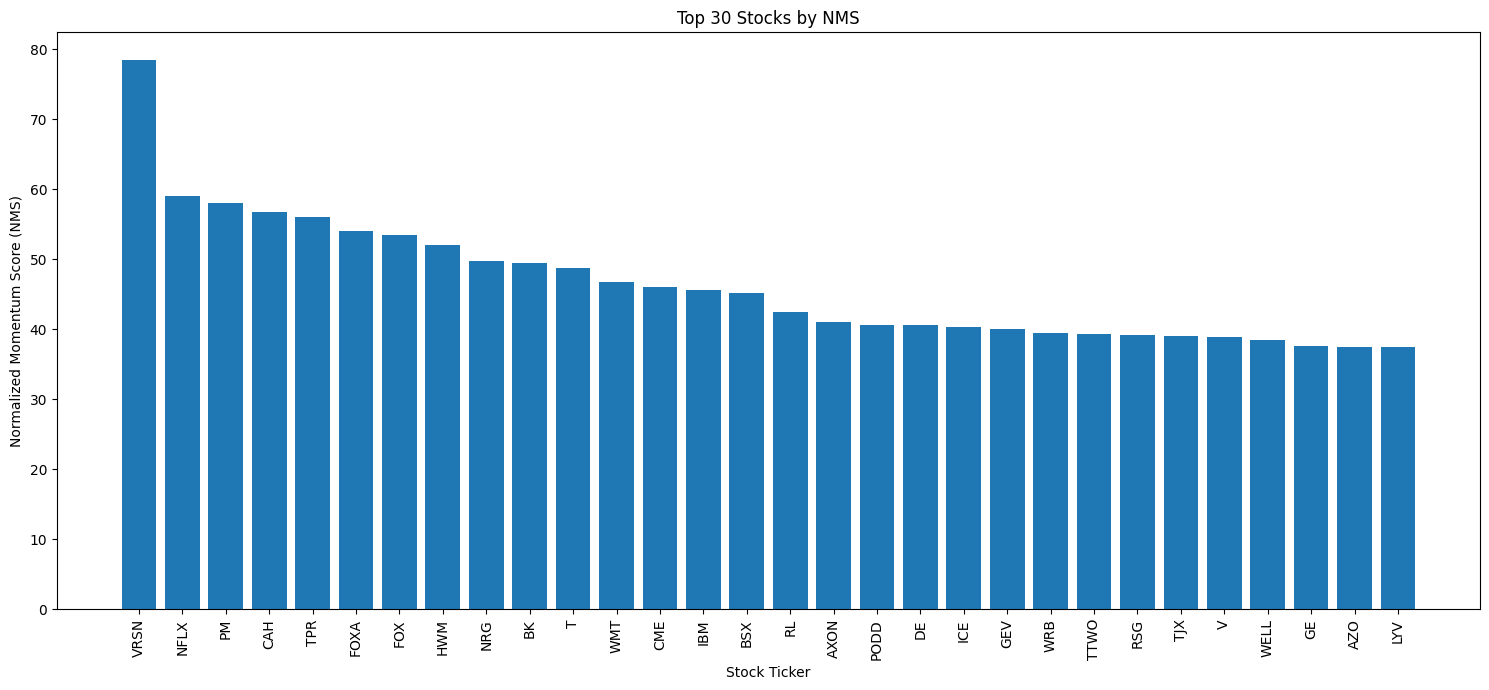

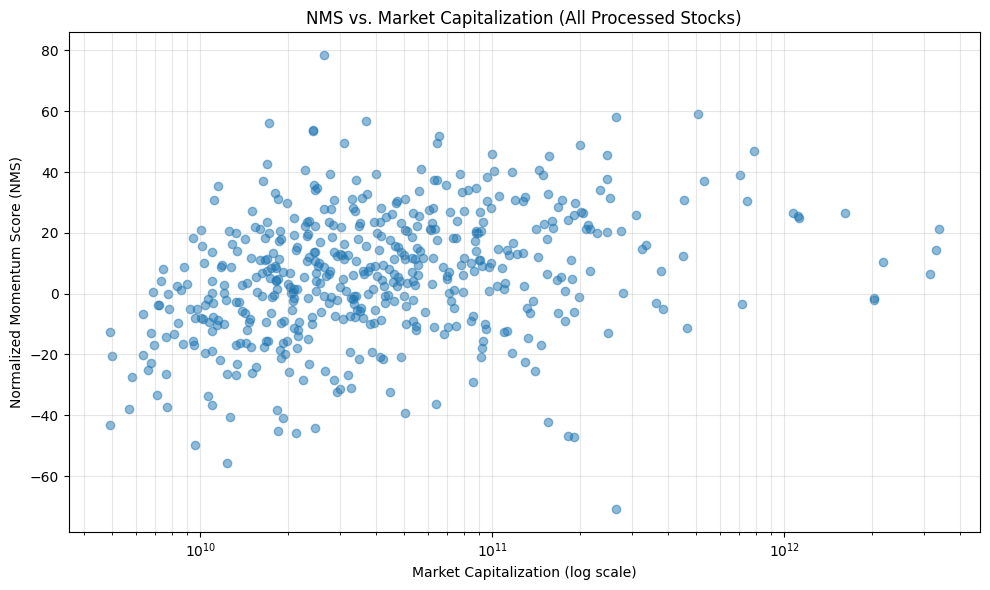


Total execution time: 52.23 seconds

All Tickers Metrics & Rank CSV:
/content/Results/finnhub_all_tickers_metrics_rank.csv

Top Stocks Weights CSV:
/content/Results/finnhub_top_stocks_weights.csv

Log File:
/content/stock_analysis.log


In [ ]:
# Install required packages (if not already installed in your Colab environment)
# !pip install finnhub-python joblib tqdm pandas numpy matplotlib

# Import necessary libraries
import finnhub
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import os
from joblib import Memory
import time
import logging
from tqdm.notebook import tqdm
from concurrent.futures import ThreadPoolExecutor
import matplotlib.pyplot as plt
from IPython.display import FileLink
from google.colab import userdata

# --- 1. Configuration & Setup ---
def setup_logging(log_file):
    """Configures basic logging."""
    logging.basicConfig(filename=log_file, level=logging.INFO,
                        format='%(asctime)s:%(levelname)s:%(module)s:%(funcName)s:%(message)s',
                        force=True)
    logging.info("Logging initialized.")

def load_api_key(secret_name="finhub"):
    """Loads API key from Colab secrets."""
    api_key = userdata.get(secret_name)
    if not api_key:
        logging.error(f"API key '{secret_name}' not found in Colab Secrets.")
        raise ValueError(f"API key '{secret_name}' not found. Please add it to Colab Secrets and ensure notebook access is enabled.")
    logging.info(f"API key '{secret_name}' loaded successfully.")
    return api_key

def initialize_finnhub_client(api_key):
    """Initializes and returns the Finnhub client."""
    return finnhub.Client(api_key=api_key)

def ensure_directories(dirs):
    """Ensures that a list of directories exist, creates them if not."""
    for d in dirs:
        os.makedirs(d, exist_ok=True)
    logging.info(f"Ensured directories exist: {dirs}")

# --- 2. Data Fetching ---
def setup_memory_cache(ticker, cache_dir_base):
    """Sets up a memory cache for a specific ticker."""
    cachedir = os.path.join(cache_dir_base, ticker)
    os.makedirs(cachedir, exist_ok=True) # Ensure ticker-specific cache dir exists
    return Memory(cachedir, verbose=0, compress=True)

def fetch_stock_data_with_retry(ticker, start_date, end_date, finnhub_client, cache_dir_base, attempts=3):
    """Fetches stock data for a ticker with retries and caching."""
    memory = setup_memory_cache(ticker, cache_dir_base)

    @memory.cache
    def fetch_data_for_caching(ticker_symbol, start_dt_str, end_dt_str): # Use string dates for cache key
        # Convert string dates back to datetime objects
        start_dt = datetime.strptime(start_dt_str, '%Y-%m-%d')
        end_dt = datetime.strptime(end_dt_str, '%Y-%m-%d')

        start_ts = int(start_dt.timestamp())
        end_ts = int(end_dt.timestamp())
        logging.info(f"Fetching fresh data for {ticker_symbol} between {start_dt.date()} and {end_dt.date()}")
        res = finnhub_client.stock_candles(ticker_symbol, 'D', start_ts, end_ts)
        if res.get('s') == 'ok' and 'c' in res and res['c'] is not None:
            df = pd.DataFrame(res)
            if not all(col in df.columns for col in ['t', 'c', 'h', 'l', 'o', 'v']):
                logging.warning(f"API response for {ticker_symbol} missing standard columns. Data: {res}")
                return pd.DataFrame()
            df['t'] = pd.to_datetime(df['t'], unit='s')
            df.set_index('t', inplace=True)
            return df[['c', 'h', 'l', 'o', 'v']]
        else:
            logging.warning(f"No data or error for {ticker_symbol} from API. Status: {res.get('s')}, Response: {res}")
            return pd.DataFrame()

    for i in range(attempts):
        try:
            # Pass dates as strings to the cached function for better hashability
            data = fetch_data_for_caching(ticker, start_date.strftime('%Y-%m-%d'), end_date.strftime('%Y-%m-%d'))
            if data is not None and not data.empty:
                return data
            elif data is None:
                 logging.warning(f"Attempt {i + 1} for {ticker}: fetch_data_for_caching returned None.")
            elif data.empty:
                 logging.info(f"Attempt {i + 1} for {ticker}: fetch_data_for_caching returned empty DataFrame.")
        except Exception as e:
            logging.error(f"Attempt {i + 1} for {ticker} failed: {e}")
            time.sleep(2 ** i)  # Exponential backoff
    logging.error(f"Failed to fetch data for {ticker} after {attempts} attempts.")
    return pd.DataFrame()

# --- 3. Core Data Processing ---
def calculate_metrics_for_ticker(ticker, stock_data_df, finnhub_client):
    """Calculates financial metrics for a single ticker given its data."""
    metrics = {
        'ticker': ticker,
        '1Month Log Returns': np.nan,
        '6Month Log Returns': np.nan,
        '1Year Log Returns': np.nan,
        'NMS': np.nan,
        'Market Capitalisation': np.nan
    }
    if stock_data_df is None or stock_data_df.empty:
        logging.warning(f"No data provided for {ticker}, cannot calculate price-based metrics.")
        # Still try to get market cap
        try:
            profile = finnhub_client.company_profile2(symbol=ticker)
            market_cap = profile.get('marketCapitalization', np.nan)
            if market_cap and not np.isnan(market_cap):
                metrics['Market Capitalisation'] = float(market_cap) * 1e6
            else:
                logging.warning(f"No market capitalization data for {ticker} from profile (no stock data): {profile}")
        except Exception as e:
            logging.error(f"Failed to fetch company profile for {ticker} (no stock data): {e}")
        return metrics


    close_prices = stock_data_df['c']
    if len(close_prices) > 22: # Needs at least 23 data points for -1 and -22
        metrics['1Month Log Returns'] = np.log(close_prices.iloc[-1] / close_prices.iloc[-22])
    if len(close_prices) > 126: # Needs at least 127
        metrics['6Month Log Returns'] = np.log(close_prices.iloc[-1] / close_prices.iloc[-126])
    if len(close_prices) > 252: # Needs at least 253
        metrics['1Year Log Returns'] = np.log(close_prices.iloc[-1] / close_prices.iloc[-252])

    daily_log_returns = np.log(close_prices / close_prices.shift(1)).dropna() # Drop first NaN
    volatility = daily_log_returns.std()

    if volatility > 0:
        # Ensure returns used are not NaN before summing. np.nansum handles NaNs correctly.
        valid_returns = [r for r in [metrics['1Month Log Returns'], metrics['6Month Log Returns'], metrics['1Year Log Returns']] if not np.isnan(r)]
        if valid_returns: # only calculate NMS if there's at least one valid log return period
            sum_log_returns = np.nansum(valid_returns)
            metrics['NMS'] = sum_log_returns / volatility
        else:
            logging.info(f"No valid log return periods for {ticker} to calculate NMS.")
    else:
        logging.info(f"Volatility is zero or NaN for {ticker}, cannot calculate NMS.")


    try:
        profile = finnhub_client.company_profile2(symbol=ticker)
        market_cap = profile.get('marketCapitalization', np.nan)
        if market_cap and not np.isnan(market_cap):
            metrics['Market Capitalisation'] = float(market_cap) * 1e6
        else:
            logging.warning(f"No market capitalization data for {ticker} from profile: {profile}")
    except Exception as e:
        logging.error(f"Failed to fetch company profile for {ticker}: {e}")

    return metrics

def process_all_tickers(tickers, start_date, end_date, finnhub_client, cache_dir_base, max_workers, retry_attempts):
    """Fetches data and calculates metrics for all tickers in parallel."""
    all_metrics_data = []
    with ThreadPoolExecutor(max_workers=max_workers) as executor:
        # Submit data fetching tasks
        future_to_ticker_data = {
            executor.submit(fetch_stock_data_with_retry, ticker, start_date, end_date, finnhub_client, cache_dir_base, retry_attempts): ticker
            for ticker in tickers
        }
        logging.info(f"Submitted {len(future_to_ticker_data)} data fetching tasks.")

        intermediate_results = {} # Store fetched data
        for future in tqdm(future_to_ticker_data.keys(), total=len(tickers), desc="Fetching stock data"):
            ticker = future_to_ticker_data[future]
            try:
                stock_data_df = future.result()
                intermediate_results[ticker] = stock_data_df
            except Exception as e:
                logging.error(f"Error fetching data for ticker {ticker} in thread: {e}")
                intermediate_results[ticker] = pd.DataFrame() # Empty df on error

        # Now submit metric calculation tasks (can also be parallelized if profile calls are slow)
        # For simplicity, doing this sequentially here, but can be another ThreadPoolExecutor
        logging.info("Calculating metrics for fetched data.")
        for ticker in tqdm(tickers, desc="Calculating metrics"):
            stock_data_df = intermediate_results.get(ticker, pd.DataFrame())
            # Market cap is fetched inside calculate_metrics_for_ticker
            metrics = calculate_metrics_for_ticker(ticker, stock_data_df, finnhub_client)
            all_metrics_data.append(metrics)

    df = pd.DataFrame(all_metrics_data)
    if 'ticker' in df.columns:
        df.set_index('ticker', inplace=True)
    return df

# --- 4. Analysis & Ranking ---
def analyze_and_rank_stocks(df):
    """Adds a rank based on NMS to the DataFrame."""
    if 'NMS' in df.columns:
        df['Rank'] = df['NMS'].rank(ascending=False, method='min')
        logging.info("Stocks ranked by NMS.")
    else:
        logging.warning("NMS column not found, skipping ranking.")
        df['Rank'] = np.nan
    return df

# --- 5. Weighting Logic ---
def calculate_portfolio_weights(df, top_n=30, cap_limit=0.05):
    """Calculates tilted and capped weights for the top N stocks."""
    if 'NMS' not in df.columns or 'Market Capitalisation' not in df.columns:
        logging.error("NMS or Market Capitalisation column missing. Cannot calculate weights.")
        return pd.DataFrame(columns=['Tilted Weight', 'Capped Weight', 'Final Weight', 'Market Capitalisation', 'NMS'])

    df_copy = df.copy()
    df_copy['Market Capitalisation'] = pd.to_numeric(df_copy['Market Capitalisation'], errors='coerce')
    df_copy['NMS'] = pd.to_numeric(df_copy['NMS'], errors='coerce')
    df_copy.dropna(subset=['NMS', 'Market Capitalisation'], inplace=True)

    if df_copy.empty:
        logging.warning("DataFrame is empty after dropping NaNs from NMS/MarketCap. Cannot calculate weights.")
        return pd.DataFrame(columns=['Tilted Weight', 'Capped Weight', 'Final Weight', 'Market Capitalisation', 'NMS'])

    top_stocks = df_copy.sort_values(by='NMS', ascending=False).head(top_n).copy()

    if top_stocks.empty:
        logging.warning(f"No stocks available after sorting and selecting top {top_n}. Cannot calculate weights.")
        return pd.DataFrame(columns=['Tilted Weight', 'Capped Weight', 'Final Weight', 'Market Capitalisation', 'NMS'])

    top_stocks.loc[:, 'Tilted Weight'] = top_stocks['Market Capitalisation'] * top_stocks['NMS']
    total_tilted_weight = top_stocks['Tilted Weight'].sum()

    if total_tilted_weight <= 0:
        logging.warning(f"Total tilted weight is non-positive ({total_tilted_weight:.2f}). "
                        f"Falling back to capped equal weights for top {len(top_stocks)} stocks.")
        num_stocks_in_top = len(top_stocks)
        if num_stocks_in_top > 0:
            equal_weight_ideal = 1.0 / num_stocks_in_top
            assigned_weight = min(equal_weight_ideal, cap_limit)
            top_stocks.loc[:, 'Final Weight'] = assigned_weight

            current_sum_final_weights = top_stocks['Final Weight'].sum()
            # Normalize if sum isn't 1 (e.g. all were capped below ideal equal weight)
            if abs(current_sum_final_weights - 1.0) > 1e-9 and current_sum_final_weights > 0:
                top_stocks.loc[:, 'Final Weight'] = top_stocks['Final Weight'] / current_sum_final_weights
        else:
            top_stocks.loc[:, 'Final Weight'] = np.nan # Or 0.0

        top_stocks.loc[:, 'Capped Weight'] = top_stocks['Final Weight']
        # 'Tilted Weight' column already exists.
        return top_stocks[['Tilted Weight', 'Capped Weight', 'Final Weight', 'Market Capitalisation', 'NMS']]

    # This part executes only if total_tilted_weight > 0
    top_stocks.loc[:, 'Tilted Weight'] = top_stocks['Tilted Weight'] / total_tilted_weight
    top_stocks.loc[:, 'Capped Weight'] = top_stocks['Tilted Weight'].apply(lambda x: min(x, cap_limit))

    max_iterations = 20
    iteration_count = 0
    while iteration_count < max_iterations:
        iteration_count += 1
        total_capped_weight = top_stocks['Capped Weight'].sum()
        if total_capped_weight == 0:
            logging.warning("Total capped weight became zero during normalization.")
            top_stocks.loc[:, 'Final Weight'] = 0.0
            break

        top_stocks.loc[:, 'Final Weight'] = top_stocks['Capped Weight'] / total_capped_weight
        over_capped_mask = top_stocks['Final Weight'] > (cap_limit + 1e-9)

        if not over_capped_mask.any():
            break

        excess_weight_sum = (top_stocks.loc[over_capped_mask, 'Final Weight'] - cap_limit).sum()
        top_stocks.loc[over_capped_mask, 'Capped Weight'] = cap_limit

        non_capped_mask = ~over_capped_mask
        sum_non_capped_weights_for_redistribution = top_stocks.loc[non_capped_mask, 'Capped Weight'].sum()

        if sum_non_capped_weights_for_redistribution > 0:
            redistribution_factor = top_stocks.loc[non_capped_mask, 'Capped Weight'] / sum_non_capped_weights_for_redistribution
            top_stocks.loc[non_capped_mask, 'Capped Weight'] += redistribution_factor * excess_weight_sum
        elif excess_weight_sum > 0:
            logging.warning("Excess weight could not be redistributed as sum of non-capped weights is zero.")
            current_sum = top_stocks['Capped Weight'].sum()
            if current_sum > 0: # Normalize what's left if all are capped
                top_stocks.loc[:, 'Capped Weight'] = top_stocks['Capped Weight'] / current_sum
            break

    if iteration_count == max_iterations:
        logging.warning(f"Weighting adjustment reached max iterations ({max_iterations}).")
    # Final normalization pass for Final Weight
    final_sum_of_weights = top_stocks['Final Weight'].sum()
    if final_sum_of_weights > 0 and abs(final_sum_of_weights - 1.0) > 1e-9:
        top_stocks.loc[:, 'Final Weight'] = top_stocks['Final Weight'] / final_sum_of_weights


    logging.info(f"Portfolio weights calculated for top {len(top_stocks)} stocks.")
    return top_stocks[['Tilted Weight', 'Capped Weight', 'Final Weight', 'Market Capitalisation', 'NMS']]


# --- 6. Reporting & Output ---
def save_dataframe_to_csv(df, filename, directory):
    """Saves a DataFrame to a CSV file."""
    if df is None or df.empty:
        logging.warning(f"DataFrame for {filename} is empty or None. Skipping save.")
        return None
    os.makedirs(directory, exist_ok=True)
    output_path = os.path.join(directory, filename)
    try:
        df.to_csv(output_path)
        logging.info(f"DataFrame saved to {output_path}")
        return output_path
    except Exception as e:
        logging.error(f"Failed to save DataFrame to {output_path}: {e}")
        return None

def generate_visualizations(all_stocks_df, top_stocks_df, result_dir):
    """Generates and shows/saves visualizations."""
    if top_stocks_df is not None and not top_stocks_df.empty and 'NMS' in top_stocks_df.columns:
        plt.figure(figsize=(15, 7))
        # Sort by NMS for consistent plotting if not already
        plot_top_stocks = top_stocks_df.sort_values(by='NMS', ascending=False)
        plt.bar(plot_top_stocks.index, plot_top_stocks['NMS'])
        plt.xlabel('Stock Ticker')
        plt.ylabel('Normalized Momentum Score (NMS)')
        plt.title(f'Top {len(plot_top_stocks)} Stocks by NMS')
        plt.xticks(rotation=90)
        plt.tight_layout()
        plot_path1 = os.path.join(result_dir, 'top_stocks_nms.png')
        plt.savefig(plot_path1)
        plt.show()
        logging.info(f"NMS distribution plot saved to {plot_path1}")
    else:
        logging.warning("Top stocks data for NMS plot is empty or NMS column missing.")

    if all_stocks_df is not None and not all_stocks_df.empty and \
       'Market Capitalisation' in all_stocks_df.columns and 'NMS' in all_stocks_df.columns:
        plot_df = all_stocks_df.dropna(subset=['Market Capitalisation', 'NMS'])
        if not plot_df.empty:
            plt.figure(figsize=(10, 6))
            plt.scatter(plot_df['Market Capitalisation'], plot_df['NMS'], alpha=0.5)
            plt.xlabel('Market Capitalization (log scale)')
            plt.ylabel('Normalized Momentum Score (NMS)')
            plt.title('NMS vs. Market Capitalization (All Processed Stocks)')
            plt.xscale('log')
            plt.grid(True, which="both", ls="-", alpha=0.3)
            plt.tight_layout()
            plot_path2 = os.path.join(result_dir, 'nms_vs_market_cap.png')
            plt.savefig(plot_path2)
            plt.show()
            logging.info(f"NMS vs Market Cap plot saved to {plot_path2}")
        else:
            logging.warning("Not enough data to plot NMS vs Market Cap after dropping NaNs.")
    else:
        logging.warning("Data for NMS vs Market Cap plot is insufficient.")

def display_download_links(file_paths_dict):
    """Displays download links for a dictionary of file paths."""
    for description, path in file_paths_dict.items():
        if path and os.path.exists(path):
            print(f"\n{description}:")
            print(FileLink(path))
        else:
            print(f"\n{description}: File not generated or path is invalid ({path}).")

# --- 7. Main Orchestration ---
def main():
    """Main function to orchestrate the stock analysis workflow."""
    LOG_FILE = './stock_analysis.log'
    CACHE_DIR_BASE = './cache'
    RESULT_DIR = './Results'
    DAYS_HISTORY = 400
    MAX_WORKERS = 10
    RETRY_ATTEMPTS = 3
    TOP_N_STOCKS_FOR_WEIGHTING = 30
    WEIGHT_CAP_LIMIT = 0.05
    FINNHUB_API_SECRET_NAME = 'finhub'

    TICKERS = ["MSFT", "AAPL", "NVDA", "GOOGL", "GOOG", "AMZN", "META", "BRK-B", "LLY", "AVGO",
        "JPM", "TSLA", "V", "WMT", "XOM", "UNH", "MA", "PG", "COST", "JNJ", "ORCL", "MRK",
        "HD", "BAC", "CVX", "NFLX", "ABBV", "AMD", "KO", "CRM", "PEP", "QCOM", "TMO", "ADBE",
        "WFC", "LIN", "DHR", "TMUS", "ACN", "CSCO", "MCD", "DIS", "AMAT", "GE", "TXN", "ABT",
        "AXP", "CAT", "INTU", "VZ", "AMGN", "PFE", "MS", "NEE", "IBM", "PM", "NOW", "CMCSA",
        "BX", "GS", "ISRG", "MU", "UNP", "RTX", "NKE", "COP", "SPGI", "ETN", "UBER", "INTC",
        "HON", "BKNG", "SCHW", "SYK", "LRCX", "T", "LOW", "C", "ELV", "PGR", "UPS", "VRTX",
        "BLK", "TJX", "ADI", "LMT", "BSX", "MDT", "CB", "BA", "REGN", "KLAC", "DE", "PANW",
        "MMC", "ADP", "PLD", "ANET", "CI", "ABNB", "MDLZ", "SNPS", "SBUX", "FI", "AMT", "CMG",
        "SO", "WM", "BMY", "HCA", "GD", "GILD", "APH", "CDNS", "DUK", "ICE", "MO", "ZTS",
        "CME", "SHW", "CL", "TT", "TDG", "MCO", "FCX", "MCK", "EQIX", "CEG", "ITW", "NXPI",
        "EOG", "CVS", "CTAS", "NOC", "PH", "MAR", "TGT", "ECL", "BDX", "SLB", "CSX", "EMR",
        "PYPL", "MRNA", "USB", "MPC", "PNC", "AON", "FDX", "MSI", "PSX", "WELL", "CARR", "RSG",
        "APD", "ROP", "ORLY", "PCAR", "MMM", "AJG", "OXY", "MNST", "VLO", "MCHP", "EW", "COF",
        "CPRT", "AIG", "SMCI", "MET", "TFC", "NSC", "HLT", "DXCM", "GM", "AFL", "JCI", "WMB",
        "TRV", "GEV", "NEM", "AZO", "SPG", "SRE", "PSA", "F", "ROST", "DHI", "GWW", "OKE",
        "AEP", "FTNT", "HES", "KDP", "ADSK", "TEL", "DLR", "STZ", "O", "EL", "URI", "PAYX",
        "KMB", "D", "BK", "A", "AMP", "COR", "KHC", "ALL", "FIS", "LEN", "PRU", "IDXX", "CCI",
        "LHX", "KMI", "HUM", "IQV", "PWR", "NUE", "DOW", "AME", "HSY", "CNC", "PCG", "OTIS",
        "CHTR", "MSCI", "CMI", "ACGL", "YUM", "CTVA", "GIS", "KR", "IR", "RCL", "FAST", "ODFL",
        "PEG", "KVUE", "EXC", "MPWR", "LULU", "GEHC", "SYY", "EA", "VRSK", "NDAQ", "MLM", "VST",
        "CSGP", "XYL", "HWM", "FANG", "VMC", "FICO", "IT", "CTSH", "DD", "DAL", "LVS", "ED",
        "BKR", "LYB", "HPQ", "HAL", "DG", "BIIB", "MTD", "GRMN", "RMD", "ON", "GLW", "CDW",
        "DFS", "PPG", "DVN", "TSCO", "EXR", "ROK", "HIG", "WAB", "ADM", "XEL", "EFX", "FSLR",
        "VICI", "ANSS", "EIX", "AVB", "EBAY", "CBRE", "FTV", "DECK", "TTWO", "TROW", "GPN",
        "RJF", "CHD", "WTW", "BRO", "WEC", "FITB", "TRGP", "DOV", "VLTO", "DLTR", "KEYS",
        "MTB", "AWK", "EQR", "IFF", "WDC", "WST", "PHM", "ZBH", "HPE", "NTAP", "BR", "IRM",
        "CAH", "DTE", "ETR", "NVR", "STT", "STE", "TER", "APTV", "FE", "ROL", "HUBB", "LYV",
        "WY", "PTC", "BF.B", "AXON", "BALL", "PPL", "INVH", "STLD", "TYL", "BLDR", "K", "TSN",
        "ARE", "LDOS", "WRB", "ES", "GPC", "SBAC", "CTRA", "WAT", "HBAN", "STX", "MOH", "MKC",
        "PFG", "ALGN", "HRL", "VTR", "CBOE", "TDY", "CCL", "AEE", "WBD", "CNP", "COO", "CPAY",
        "OMC", "CINF", "CMS", "ULTA", "AVY", "NRG", "EQT", "DRI", "J", "DPZ", "RF", "SYF",
        "BAX", "HOLX", "VRSN", "NTRS", "ENPH", "EG", "UAL", "ATO", "ILMN", "TXT", "LH", "ZBRA",
        "CE", "EXPD", "ESS", "FDS", "L", "PKG", "CLX", "IEX", "JBHT", "CFG", "LUV", "IP", "DGX",
        "GEN", "MAA", "BBY", "NWSA", "NWS", "MAS", "FOXA", "FOX", "ALB", "AES", "SWKS", "BG",
        "CAG", "JBL", "MRO", "AMCR", "AKAM", "SNA", "CF", "EXPE", "RVTY", "WRK", "POOL", "TRMB",
        "WBA", "PNR", "KEY", "NDSN", "CPB", "DOC", "SWK", "HST", "INCY", "LW", "UDR", "LNT",
        "TECH", "PODD", "NI", "MGM", "KIM", "AOS", "VTRS", "JKHY", "EVRG", "BEN", "DVA", "IPG",
        "EMN", "SJM", "LKQ", "JNPR", "CRL", "RL", "CPT", "KMX", "REG", "APA", "BBWI", "ALLE",
        "WYNN", "TAP", "UHS", "EPAM", "SOLV", "CHRW", "HII", "MOS", "FFIV", "CTLT", "PAYC",
        "TFX", "TPR", "QRVO", "BXP", "HSIC", "AAL", "GNRC", "DAY", "AIZ", "PNW", "HAS", "PARA",
        "BIO", "MKTX", "FRT", "BWA", "MTCH", "FMC", "GL", "MHK", "CZR", "ETSY", "IVZ", "RHI",
        "NCLH", "CMA"] # Ensure this is your full list

    pd.set_option('display.float_format', '{:,.2f}'.format)

    start_time = time.time()
    setup_logging(LOG_FILE)
    ensure_directories([CACHE_DIR_BASE, RESULT_DIR])

    try:
        api_key = load_api_key(FINNHUB_API_SECRET_NAME)
        finnhub_client = initialize_finnhub_client(api_key)
    except ValueError as e:
        logging.critical(f"Initialization failed: {e}")
        print(f"Critical error: {e}. Exiting.")
        return

    end_date = datetime.now()
    start_date = end_date - timedelta(days=DAYS_HISTORY)
    logging.info(f"Data fetching period: {start_date.date()} to {end_date.date()}")

    logging.info(f"Starting processing for {len(TICKERS)} tickers.")
    all_stocks_df = process_all_tickers(TICKERS, start_date, end_date, finnhub_client, CACHE_DIR_BASE, MAX_WORKERS, RETRY_ATTEMPTS)

    if all_stocks_df.empty:
        logging.error("No data processed for any tickers. Exiting.")
        print("No data could be processed. Check logs.")
        return

    all_stocks_df = analyze_and_rank_stocks(all_stocks_df.copy())

    top_weighted_stocks_df = calculate_portfolio_weights(
        all_stocks_df.copy(),
        top_n=TOP_N_STOCKS_FOR_WEIGHTING,
        cap_limit=WEIGHT_CAP_LIMIT
    )

    all_ranks_output_path = save_dataframe_to_csv(
        all_stocks_df[['NMS', 'Rank', 'Market Capitalisation', '1Month Log Returns', '6Month Log Returns', '1Year Log Returns']],
        'finnhub_all_tickers_metrics_rank.csv',
        RESULT_DIR
    )
    top_30_output_path = save_dataframe_to_csv(
        top_weighted_stocks_df,
        'finnhub_top_stocks_weights.csv',
        RESULT_DIR
    )

    generate_visualizations(all_stocks_df, top_weighted_stocks_df, RESULT_DIR)

    execution_time = time.time() - start_time
    logging.info(f"Total execution time: {execution_time:.2f} seconds")
    print(f"\nTotal execution time: {execution_time:.2f} seconds")

    file_links = {}
    if all_ranks_output_path:
        file_links["All Tickers Metrics & Rank CSV"] = all_ranks_output_path
    if top_30_output_path:
        file_links["Top Stocks Weights CSV"] = top_30_output_path
    file_links["Log File"] = LOG_FILE

    display_download_links(file_links)

if __name__ == "__main__":
    main()

In [ ]:
import finnhub
import json # For pretty printing the JSON response
from google.colab import userdata # To access Colab secrets

# --- Configuration ---
FINNHUB_API_SECRET_NAME = 'finhub' # Make sure this matches your Finnhub secret name
INDEX_SYMBOL = "^GSPC" # Standard symbol for S&P 500

# --- Load API Key ---
try:
    finnhub_api_key = userdata.get(FINNHUB_API_SECRET_NAME)
    if not finnhub_api_key:
        print(f"ERROR: Finnhub API key secret '{FINNHUB_API_SECRET_NAME}' not found or is empty in Colab Secrets.")
        print("Please add your Finnhub API key to Colab Secrets and ensure notebook access is enabled.")
        raise SystemExit("Finnhub API Key not found.")
    print(f"Successfully loaded Finnhub API key from secret '{FINNHUB_API_SECRET_NAME}'.")
except Exception as e:
    print(f"An error occurred trying to load the Finnhub API key: {e}")
    raise SystemExit("Failed to load Finnhub API Key.")

# --- Initialize Finnhub Client ---
try:
    finnhub_client = finnhub.Client(api_key=finnhub_api_key)
    print("Finnhub client initialized successfully.")
except Exception as e:
    print(f"Error initializing Finnhub client: {e}")
    raise SystemExit("Failed to initialize Finnhub client.")

# --- Finnhub API Call for Index Constituents ---
print(f"\nAttempting to fetch constituents for index: {INDEX_SYMBOL} using Finnhub...")

tickers_found = []
raw_response_data = None

try:
    # Call the indices_constituents method
    # Note: The method in the library might be indices_const or indices_constituents
    # The GitHub examples often use indices_const
    constituents_data = finnhub_client.indices_const(symbol=INDEX_SYMBOL)
    raw_response_data = constituents_data # Store for inspection

    if constituents_data:
        print("\nSUCCESS: Request to Finnhub for index constituents was successful.")

        # --- Inspect the Data Structure ---
        # Expected structure based on documentation:
        # {
        #   "symbol": "^GSPC",
        #   "constituents": ["AAPL", "MSFT", ...],
        #   "constituentsBreakdown": [ { "symbol": "AAPL", "name": "Apple Inc", ...}, ... ] (Premium?)
        # }
        # The free version might just give "constituents".

        print("\nRaw response structure:")
        print(json.dumps(raw_response_data, indent=4))

        if 'symbol' in raw_response_data:
            print(f"\nIndex Symbol from response: {raw_response_data['symbol']}")

        if 'constituents' in raw_response_data and isinstance(raw_response_data['constituents'], list):
            tickers_found = raw_response_data['constituents']
            print(f"\nSuccessfully extracted {len(tickers_found)} ticker symbols from the 'constituents' list.")
            if tickers_found:
                print(f"First 5 symbols found: {tickers_found[:5]}")
                # Finnhub usually provides tickers in a format that its other endpoints accept (e.g., BRK-B)
                # but it's good to double-check.
                for s_ticker in tickers_found:
                    if '.' in s_ticker:
                        print(f"Note: Found ticker with '.' in Finnhub response: {s_ticker}. This is unusual for Finnhub but possible.")
                        break
        else:
            print("\nWARNING: 'constituents' key not found in the response or is not a list.")
            print("Please inspect the raw data structure above to understand how to extract tickers.")

        # Optional: Check for 'constituentsBreakdown' if you have a premium key and want more details
        if 'constituentsBreakdown' in raw_response_data:
            print("\n'constituentsBreakdown' found (often a premium feature):")
            if isinstance(raw_response_data['constituentsBreakdown'], list) and len(raw_response_data['constituentsBreakdown']) > 0:
                print(f"Breakdown contains {len(raw_response_data['constituentsBreakdown'])} items.")
                print("First item from breakdown:")
                print(json.dumps(raw_response_data['constituentsBreakdown'][0], indent=4))
            else:
                print("Breakdown list is empty or not a list.")
        else:
            print("\n'constituentsBreakdown' not found in the response.")

    else:
        # This case might occur if the API returns an empty successful response
        # or if the client library returns None on certain non-200 statuses
        # without raising an exception.
        print(f"\nWARNING: Finnhub API returned no data or an unexpected empty response for {INDEX_SYMBOL}.")
        print("This could indicate the symbol is not supported by this endpoint with your API key, or an API issue.")

except finnhub.FinnhubAPIException as e: # Catch Finnhub specific API errors
    print(f"\nERROR: Finnhub API Exception occurred: {e}")
    print(f"Status Code: {e.status_code if hasattr(e, 'status_code') else 'N/A'}")
    if e.status_code == 401:
        print("This usually means your Finnhub API key is invalid or expired.")
    elif e.status_code == 403:
        print("Forbidden - Your API key may not have permission for this endpoint (e.g. premium feature).")
    elif e.status_code == 429:
        print("Too Many Requests - You've hit a rate limit.")
    else:
        print("Check if the index symbol is correct and supported by your Finnhub plan.")
except requests.exceptions.RequestException as e: # Catch underlying requests library errors
    print(f"\nCRITICAL ERROR: A network request exception occurred: {e}")
    print("Check your internet connection.")
except Exception as e:
    print(f"\nCRITICAL ERROR: An unexpected error occurred: {e}")

print("\n--- Finnhub Index Constituents Test Script Finished ---")

Successfully loaded Finnhub API key from secret 'finhub'.
Finnhub client initialized successfully.

Attempting to fetch constituents for index: ^GSPC using Finnhub...

SUCCESS: Request to Finnhub for index constituents was successful.

Raw response structure:
{
    "atDate": "2025-05-15",
    "constituents": [
        "MSFT",
        "NVDA",
        "AAPL",
        "AMZN",
        "META",
        "AVGO",
        "TSLA",
        "GOOGL",
        "BRK.B",
        "GOOG",
        "JPM",
        "V",
        "LLY",
        "NFLX",
        "MA",
        "XOM",
        "COST",
        "WMT",
        "PG",
        "HD",
        "JNJ",
        "ABBV",
        "BAC",
        "CRM",
        "KO",
        "PM",
        "PLTR",
        "ORCL",
        "CSCO",
        "UNH",
        "WFC",
        "IBM",
        "GE",
        "CVX",
        "ABT",
        "MCD",
        "LIN",
        "NOW",
        "DIS",
        "ACN",
        "ISRG",
        "T",
        "GS",
        "MRK",
        "UBER",
    

Fetching Finnhub candle data:   0%|          | 0/503 [00:00<?, ?it/s]

Calculating metrics & profiles:   0%|          | 0/503 [00:00<?, ?it/s]

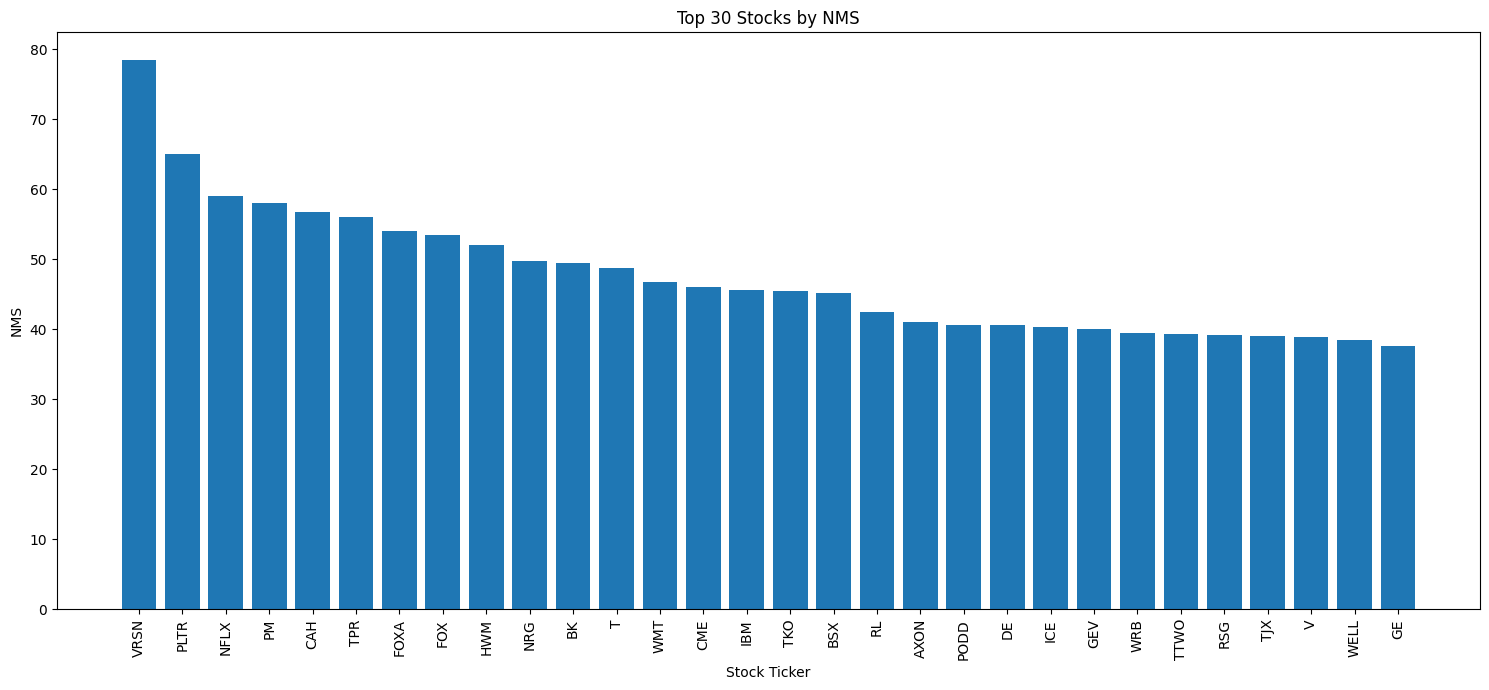

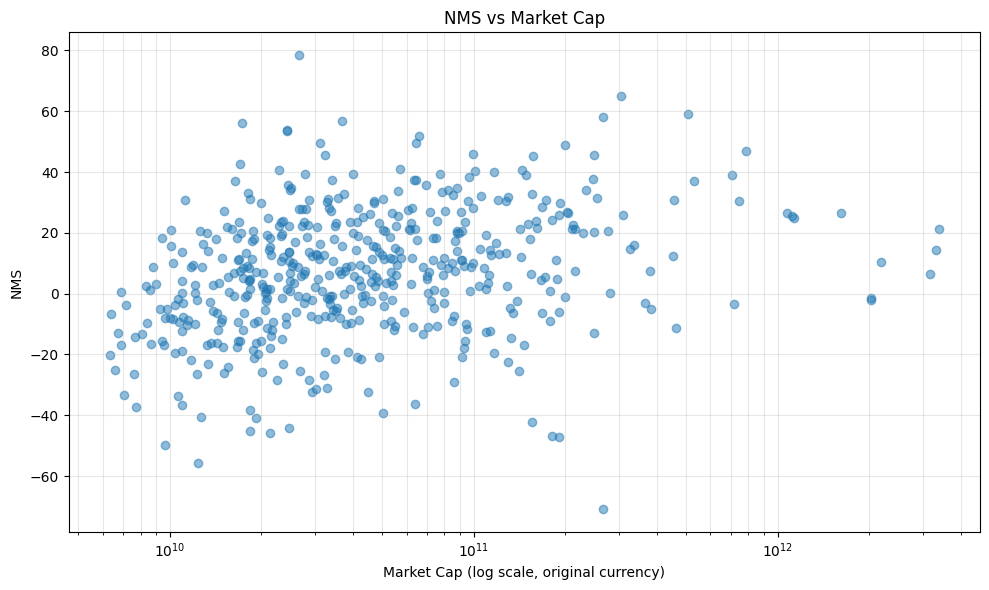


All Analyzed Tickers CSV:
/content/Results_multi_index/finnhub_all_analyzed_metrics_rank.csv

Top Stocks Weights CSV:
/content/Results_multi_index/finnhub_top_stocks_weights.csv

Log File:
/content/stock_analysis_multi_index.log

Total execution time: 18.21 seconds


In [ ]:
#indices added from finhub contituents no need for indiax consituents members managment.

# Install required packages (if not already installed in your Colab environment)
# !pip install finnhub-python joblib tqdm pandas numpy matplotlib requests

# Import necessary libraries
import finnhub
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import os
from joblib import Memory
import time
import logging
from tqdm.notebook import tqdm
from concurrent.futures import ThreadPoolExecutor
import matplotlib.pyplot as plt
from IPython.display import FileLink
from google.colab import userdata
import requests # Kept for potential future use, but not for current ticker fetching

# --- 1. Configuration & Setup ---
def setup_logging(log_file):
    logging.basicConfig(filename=log_file, level=logging.INFO,
                        format='%(asctime)s:%(levelname)s:%(module)s:%(funcName)s:%(message)s',
                        force=True)
    logging.info("Logging initialized.")

def load_api_key_from_secrets(secret_name, provider_name=""):
    api_key = userdata.get(secret_name)
    if not api_key:
        error_msg = f"{provider_name} API key '{secret_name}' not found in Colab Secrets."
        logging.error(error_msg)
        raise ValueError(f"{error_msg} Please add it and ensure notebook access is enabled.")
    logging.info(f"{provider_name} API key '{secret_name}' loaded successfully.")
    return api_key

def initialize_finnhub_client(api_key):
    return finnhub.Client(api_key=api_key)

def ensure_directories(dirs):
    for d in dirs:
        os.makedirs(d, exist_ok=True)
    logging.info(f"Ensured directories exist: {dirs}")

# --- Index Constituent Fetching (Finnhub) ---
def get_index_constituents_finnhub(finnhub_client, index_symbol):
    """
    Fetches constituents for a given index symbol using Finnhub API.
    Returns a list of ticker symbols or None if fetching fails.
    """
    logging.info(f"Attempting to fetch constituents for index: {index_symbol} using Finnhub...")
    try:
        constituents_data = finnhub_client.indices_const(symbol=index_symbol)
        if constituents_data and 'constituents' in constituents_data and isinstance(constituents_data['constituents'], list):
            tickers = constituents_data['constituents']
            # Finnhub generally returns tickers in its preferred format (e.g., BRK-B).
            # No explicit normalization needed at this stage unless issues are found with specific indices.
            logging.info(f"Successfully fetched {len(tickers)} constituents for index {index_symbol} from Finnhub.")
            return tickers
        else:
            logging.warning(f"No 'constituents' list found or unexpected format for index {index_symbol} from Finnhub. Response: {str(constituents_data)[:200]}")
            return None
    except finnhub.FinnhubAPIException as e:
        logging.error(f"Finnhub API Exception for index {index_symbol}: {e} (Status: {e.status_code if hasattr(e, 'status_code') else 'N/A'})")
        return None
    except Exception as e:
        logging.error(f"Generic error fetching constituents for index {index_symbol} from Finnhub: {e}")
        return None

# --- 2. Data Fetching (Stock Data from Finnhub) ---
def setup_memory_cache(ticker, cache_dir_base):
    # Sanitize ticker for directory name if it contains problematic characters (e.g., '^')
    # Though Finnhub tickers like BRK-B, AAPL, VOD.L should be fine.
    sanitized_ticker_for_path = ticker.replace('^', '_') # Example for index symbols if they were used directly
    cachedir = os.path.join(cache_dir_base, sanitized_ticker_for_path)
    os.makedirs(cachedir, exist_ok=True)
    return Memory(cachedir, verbose=0, compress=True)

def fetch_stock_data_with_retry(ticker, start_date, end_date, finnhub_client, cache_dir_base, attempts=3):
    memory = setup_memory_cache(ticker, cache_dir_base)

    @memory.cache
    def fetch_data_for_caching(ticker_symbol, start_dt_str, end_dt_str):
        start_dt = datetime.strptime(start_dt_str, '%Y-%m-%d')
        end_dt = datetime.strptime(end_dt_str, '%Y-%m-%d')
        start_ts = int(start_dt.timestamp())
        end_ts = int(end_dt.timestamp())

        if not ticker_symbol or not isinstance(ticker_symbol, str) or len(ticker_symbol) > 15: # Increased length for international
            logging.warning(f"Skipping Finnhub candle fetch for potentially invalid ticker: '{ticker_symbol}'")
            return pd.DataFrame()

        logging.debug(f"Attempting to fetch fresh candle data for {ticker_symbol} from Finnhub.")
        res = finnhub_client.stock_candles(ticker_symbol, 'D', start_ts, end_ts)

        if res.get('s') == 'ok' and 'c' in res and res['c'] is not None and len(res['c']) > 0 :
            df = pd.DataFrame(res)
            if not all(col in df.columns for col in ['t', 'c', 'h', 'l', 'o', 'v']):
                logging.warning(f"Finnhub candle response for {ticker_symbol} missing standard columns. Data: {res}")
                return pd.DataFrame()
            df['t'] = pd.to_datetime(df['t'], unit='s')
            df.set_index('t', inplace=True)
            logging.debug(f"Successfully fetched candle data for {ticker_symbol} from Finnhub.")
            return df[['c', 'h', 'l', 'o', 'v']]
        else:
            # Log 'no data' as info, as it's a common valid case for an unrecognized/delisted ticker.
            logging.info(f"No candle data or 's' not 'ok' for {ticker_symbol} from Finnhub. Status: {res.get('s')}, Response excerpt: {str(res)[:200]}")
            return pd.DataFrame()

    for i in range(attempts):
        try:
            data = fetch_data_for_caching(ticker, start_date.strftime('%Y-%m-%d'), end_date.strftime('%Y-%m-%d'))
            if data is not None and not data.empty:
                return data
            elif data is None: # Should not happen if fetch_data_for_caching always returns a DF
                 logging.warning(f"Attempt {i + 1} for {ticker} (Finnhub candles): fetch_data_for_caching returned None.")
            elif data.empty:
                 logging.info(f"Attempt {i + 1} for {ticker} (Finnhub candles): fetch_data_for_caching returned empty DataFrame (likely no data at source).")
                 # Return empty DF immediately if that's the confirmed result from cache/API for this attempt
                 return pd.DataFrame()
        except Exception as e:
            logging.error(f"Attempt {i + 1} for {ticker} (Finnhub candles) failed: {e}")
            time.sleep(2 ** i)
    logging.error(f"Failed to fetch candle data for {ticker} from Finnhub after {attempts} attempts.")
    return pd.DataFrame()

# --- 3. Core Data Processing (Finnhub) ---
def calculate_metrics_for_ticker(ticker, stock_data_df, finnhub_client):
    metrics = {
        'ticker': ticker,
        '1Month Log Returns': np.nan, '6Month Log Returns': np.nan, '1Year Log Returns': np.nan,
        'NMS': np.nan, 'Market Capitalisation': np.nan, 'Currency': None # Added currency
    }
    if stock_data_df is None or stock_data_df.empty:
        logging.info(f"No Finnhub price data for {ticker}, cannot calculate price-based metrics.")
    else:
        close_prices = stock_data_df['c']
        # Ensure sufficient data points for each calculation
        if len(close_prices) >= 22: # 22 periods = 23 data points (-1 to -22 inclusive)
            metrics['1Month Log Returns'] = np.log(close_prices.iloc[-1] / close_prices.iloc[-22])
        if len(close_prices) >= 126: # 126 periods = 127 data points
            metrics['6Month Log Returns'] = np.log(close_prices.iloc[-1] / close_prices.iloc[-126])
        if len(close_prices) >= 252: # 252 periods = 253 data points
            metrics['1Year Log Returns'] = np.log(close_prices.iloc[-1] / close_prices.iloc[-252])

        daily_log_returns = np.log(close_prices / close_prices.shift(1)).dropna()
        volatility = daily_log_returns.std()

        if volatility > 0:
            valid_returns = [r for r in [metrics['1Month Log Returns'], metrics['6Month Log Returns'], metrics['1Year Log Returns']] if not np.isnan(r)]
            if valid_returns:
                metrics['NMS'] = np.nansum(valid_returns) / volatility
            else: logging.debug(f"No valid log return periods for NMS for {ticker}.")
        else: logging.debug(f"Volatility is zero or NaN for {ticker}, cannot calculate NMS.")

    try:
        if not ticker or not isinstance(ticker, str) or len(ticker) > 15:
            logging.warning(f"Skipping Finnhub profile fetch for potentially invalid ticker: '{ticker}'")
        else:
            profile = finnhub_client.company_profile2(symbol=ticker)
            market_cap_raw = profile.get('marketCapitalization', np.nan) # In millions by default
            metrics['Currency'] = profile.get('currency', None) # Get currency

            if market_cap_raw and not np.isnan(market_cap_raw):
                metrics['Market Capitalisation'] = float(market_cap_raw) * 1e6 # Convert millions to actual
            else:
                logging.info(f"Market cap is None or NaN for {ticker} from Finnhub. Profile: {str(profile)[:100]}")
    except finnhub.FinnhubAPIException as e:
        logging.warning(f"Finnhub API Exception fetching profile for {ticker}: {e} (Status: {e.status_code if hasattr(e, 'status_code') else 'N/A'})")
    except Exception as e:
        logging.error(f"Generic error fetching profile for {ticker} from Finnhub: {e}")
    return metrics

def process_all_tickers(tickers_to_process, start_date, end_date, finnhub_client, cache_dir_base, max_workers_candles, max_workers_profile, retry_attempts):
    all_metrics_data = []
    if not tickers_to_process:
        logging.warning("Ticker list for processing is empty.")
        return pd.DataFrame()

    intermediate_results = {} # To store candle data
    logging.info(f"Fetching candle data for {len(tickers_to_process)} unique tickers...")
    with ThreadPoolExecutor(max_workers=max_workers_candles, thread_name_prefix='CandleFetcher') as executor:
        future_to_ticker_candles = {
            executor.submit(fetch_stock_data_with_retry, ticker, start_date, end_date, finnhub_client, cache_dir_base, retry_attempts): ticker
            for ticker in tickers_to_process
        }
        for future in tqdm(future_to_ticker_candles.keys(), total=len(tickers_to_process), desc="Fetching Finnhub candle data"):
            ticker = future_to_ticker_candles[future]
            try:
                intermediate_results[ticker] = future.result()
            except Exception as e:
                logging.error(f"Error retrieving candle data future for {ticker}: {e}")
                intermediate_results[ticker] = pd.DataFrame()

    logging.info(f"Calculating metrics (including profiles) for {len(tickers_to_process)} tickers...")
    with ThreadPoolExecutor(max_workers=max_workers_profile, thread_name_prefix='ProfileMetricCalc') as executor:
        future_to_metrics = {
            executor.submit(calculate_metrics_for_ticker, ticker, intermediate_results.get(ticker, pd.DataFrame()), finnhub_client): ticker
            for ticker in tickers_to_process
        }
        for future in tqdm(future_to_metrics.keys(), total=len(tickers_to_process), desc="Calculating metrics & profiles"):
            ticker = future_to_metrics[future]
            try:
                metrics = future.result()
                all_metrics_data.append(metrics)
            except Exception as e:
                logging.error(f"Error retrieving metrics future for {ticker}: {e}")
                all_metrics_data.append({'ticker': ticker, 'NMS': np.nan, 'Market Capitalisation': np.nan, 'Currency': None})

    df = pd.DataFrame(all_metrics_data)
    if 'ticker' in df.columns:
        df.set_index('ticker', inplace=True)
    return df

# --- 4. Analysis & Ranking ---
def analyze_and_rank_stocks(df):
    if df.empty: return df
    if 'NMS' in df.columns:
        df['Rank'] = df['NMS'].rank(ascending=False, method='min')
        logging.info("Stocks ranked by NMS.")
    else:
        logging.warning("NMS column not found, skipping ranking."); df['Rank'] = np.nan
    return df

# --- 5. Weighting Logic ---
def calculate_portfolio_weights(df, top_n=30, cap_limit=0.05):
    # (Ensure Market Capitalisation is converted to a common currency before this if mixing international stocks significantly)
    # For now, assuming all market caps are comparable or currency effects are ignored for this step.
    # TODO: Future enhancement: Convert all Market Caps to USD (or other base currency) using exchange rates.
    if df.empty: return pd.DataFrame(columns=['Tilted Weight', 'Capped Weight', 'Final Weight', 'Market Capitalisation', 'NMS', 'Currency'])
    if 'NMS' not in df.columns or 'Market Capitalisation' not in df.columns:
        logging.error("NMS or MarketCap missing for weighting."); return pd.DataFrame(columns=['Tilted Weight', 'Capped Weight', 'Final Weight', 'Market Capitalisation', 'NMS', 'Currency'])

    df_copy = df.copy()
    df_copy['Market Capitalisation'] = pd.to_numeric(df_copy['Market Capitalisation'], errors='coerce')
    df_copy['NMS'] = pd.to_numeric(df_copy['NMS'], errors='coerce')
    # Keep Currency column if it exists
    cols_to_return = ['Tilted Weight', 'Capped Weight', 'Final Weight', 'Market Capitalisation', 'NMS']
    if 'Currency' in df_copy.columns:
        cols_to_return.append('Currency')


    df_copy.dropna(subset=['NMS', 'Market Capitalisation'], inplace=True)
    if df_copy.empty:
        logging.warning("Weighting: DataFrame empty after NaNs drop."); return pd.DataFrame(columns=cols_to_return)

    top_stocks = df_copy.sort_values(by='NMS', ascending=False).head(top_n).copy()
    if top_stocks.empty:
        logging.warning(f"Weighting: No stocks after top {top_n}."); return pd.DataFrame(columns=cols_to_return)

    top_stocks.loc[:, 'Tilted Weight'] = top_stocks['Market Capitalisation'] * top_stocks['NMS']
    total_tilted_weight = top_stocks['Tilted Weight'].sum()

    if total_tilted_weight <= 0:
        logging.warning(f"Total tilted weight non-positive ({total_tilted_weight:.2f}). Fallback to capped equal weights.")
        num_s = len(top_stocks)
        if num_s > 0:
            assigned_w = min(1.0 / num_s, cap_limit)
            top_stocks.loc[:, 'Final Weight'] = assigned_w
            current_sum_fw = top_stocks['Final Weight'].sum()
            if abs(current_sum_fw - 1.0) > 1e-9 and current_sum_fw > 0: top_stocks.loc[:, 'Final Weight'] /= current_sum_fw
        else: top_stocks.loc[:, 'Final Weight'] = np.nan
        top_stocks.loc[:, 'Capped Weight'] = top_stocks['Final Weight']
        return top_stocks[cols_to_return].fillna(0) # FillNa for weights if any issues

    top_stocks.loc[:, 'Tilted Weight'] /= total_tilted_weight
    top_stocks.loc[:, 'Capped Weight'] = top_stocks['Tilted Weight'].apply(lambda x: min(x, cap_limit))
    # Iterative adjustment (remains largely the same)
    max_iter, i_count = 20, 0
    while i_count < max_iter:
        i_count += 1; total_cap_w = top_stocks['Capped Weight'].sum()
        if total_cap_w == 0: logging.warning("Total cap_w zero."); top_stocks.loc[:, 'Final Weight'] = 0.0; break
        top_stocks.loc[:, 'Final Weight'] = top_stocks['Capped Weight'] / total_cap_w
        over_cap_mask = top_stocks['Final Weight'] > (cap_limit + 1e-9)
        if not over_cap_mask.any(): break
        excess_sum = (top_stocks.loc[over_cap_mask, 'Final Weight'] - cap_limit).sum()
        top_stocks.loc[over_cap_mask, 'Capped Weight'] = cap_limit; non_cap_mask = ~over_cap_mask
        sum_non_cap_w_rd = top_stocks.loc[non_cap_mask, 'Capped Weight'].sum()
        if sum_non_cap_w_rd > 0:
            rd_factor = top_stocks.loc[non_cap_mask, 'Capped Weight'] / sum_non_cap_w_rd
            top_stocks.loc[non_cap_mask, 'Capped Weight'] += rd_factor * excess_sum
        elif excess_sum > 0: logging.warning("Excess un-distributable."); break
    if i_count == max_iter: logging.warning("Max iter in weight_adj.")
    final_sum_fw = top_stocks['Final Weight'].sum()
    if final_sum_fw > 0 and abs(final_sum_fw - 1.0) > 1e-9: top_stocks.loc[:, 'Final Weight'] /= final_sum_fw

    logging.info(f"Portfolio weights calculated for {len(top_stocks)} stocks.")
    return top_stocks[cols_to_return]

# --- 6. Reporting & Output ---
def save_dataframe_to_csv(df, filename, directory):
    if df is None or df.empty: logging.warning(f"DF {filename} empty. Skip save."); return None
    os.makedirs(directory, exist_ok=True); path = os.path.join(directory, filename)
    try: df.to_csv(path); logging.info(f"DF saved: {path}"); return path
    except Exception as e: logging.error(f"Fail save {path}: {e}"); return None

def generate_visualizations(all_df, top_df, res_dir):
    # Add Currency info to plot titles if available and diverse
    if top_df is not None and not top_df.empty and 'NMS' in top_df.columns:
        plt.figure(figsize=(15,7)); plot_top = top_df.sort_values(by='NMS', ascending=False)
        plt.bar(plot_top.index, plot_top['NMS']); plt.xlabel('Stock Ticker'); plt.ylabel('NMS')
        plt.title(f'Top {len(plot_top)} Stocks by NMS'); plt.xticks(rotation=90); plt.tight_layout()
        p1 = os.path.join(res_dir,'top_stocks_nms.png'); plt.savefig(p1); plt.show(); logging.info(f"Plot saved: {p1}")
    else: logging.warning("No NMS plot for top stocks.")
    if all_df is not None and not all_df.empty and 'Market Capitalisation' in all_df.columns and 'NMS' in all_df.columns:
        plot_a_df = all_df.dropna(subset=['Market Capitalisation','NMS'])
        if not plot_a_df.empty:
            plt.figure(figsize=(10,6)); plt.scatter(plot_a_df['Market Capitalisation'], plot_a_df['NMS'], alpha=0.5)
            plt.xlabel('Market Cap (log scale, original currency)'); plt.ylabel('NMS'); plt.title('NMS vs Market Cap')
            plt.xscale('log'); plt.grid(True,which="both",ls="-",alpha=0.3); plt.tight_layout()
            p2 = os.path.join(res_dir,'nms_vs_market_cap.png'); plt.savefig(p2); plt.show(); logging.info(f"Plot saved: {p2}")
        else: logging.warning("Not enough data for NMS vs MC plot after NaNs drop.")
    else: logging.warning("Insufficient data for NMS vs MC plot.")

def display_download_links(paths):
    for desc, path in paths.items():
        if path and os.path.exists(path): print(f"\n{desc}:\n{FileLink(path)}")
        else: print(f"\n{desc}: File not generated/path invalid ({path}).")

# --- 7. Main Orchestration ---
def main():
    LOG_FILE = './stock_analysis_multi_index.log'; CACHE_DIR_BASE = './cache_multi_index'; RESULT_DIR = './Results_multi_index'
    DAYS_HISTORY = 400; MAX_WORKERS_CANDLES = 10; MAX_WORKERS_PROFILE = 5 # Adjust profile workers for rate limits
    RETRY_ATTEMPTS = 3; TOP_N_STOCKS = 30; WEIGHT_CAP = 0.05
    FINNHUB_API_SECRET = 'finhub'

    # --- Key Configuration: Define Target Market Indices ---
    # Example: ["^GSPC"] for S&P 500
    # Example: ["^GSPC", "^NDX"] for S&P 500 and Nasdaq 100
    # Example: ["^GSPC", "^FTSE"] for S&P 500 (US) and FTSE 100 (UK) - Finnhub symbol for FTSE 100 might be different
    # Check Finnhub documentation for correct symbols for international indices (e.g., FTSE 100 might be '^FTAS' or specific like 'IX.FTSE.UKX')
    TARGET_INDICES = ["^GSPC"] # Default to S&P 500. Expand this list for more indices.

    pd.set_option('display.float_format', '{:,.2f}'.format)
    start_time = time.time()
    setup_logging(LOG_FILE)
    ensure_directories([CACHE_DIR_BASE, RESULT_DIR])

    try:
        finnhub_api_key = load_api_key_from_secrets(FINNHUB_API_SECRET, "Finnhub")
        finnhub_client = initialize_finnhub_client(finnhub_api_key)
    except ValueError as e:
        logging.critical(f"Finnhub API Key Init failed: {e}"); print(f"CRITICAL: {e}"); return

    # --- Fetch Constituents for all Target Indices ---
    all_raw_tickers_from_indices = []
    for index_sym in TARGET_INDICES:
        const_tickers = get_index_constituents_finnhub(finnhub_client, index_sym)
        if const_tickers:
            all_raw_tickers_from_indices.extend(const_tickers)
        else:
            logging.warning(f"Could not retrieve constituents for index {index_sym}. It will be skipped.")

    if not all_raw_tickers_from_indices:
        logging.critical(f"No constituents retrieved for any of the target indices: {TARGET_INDICES}. Exiting.")
        print(f"Failed to get constituents for all target indices. Check logs.")
        return

    # Get unique tickers if multiple indices are processed and might have overlaps
    unique_tickers_to_process = sorted(list(set(all_raw_tickers_from_indices)))
    logging.info(f"Total unique tickers to process from {len(TARGET_INDICES)} target index/indices: {len(unique_tickers_to_process)}")
    if not unique_tickers_to_process: # Should be caught above, but as a safeguard
        logging.critical("Unique ticker list is empty after fetching constituents. Exiting.")
        return

    end_d = datetime.now(); start_d = end_d - timedelta(days=DAYS_HISTORY)
    logging.info(f"Data period: {start_d.date()} to {end_d.date()}")

    all_stocks_df = process_all_tickers(unique_tickers_to_process, start_d, end_d, finnhub_client, CACHE_DIR_BASE, MAX_WORKERS_CANDLES, MAX_WORKERS_PROFILE, RETRY_ATTEMPTS)
    if all_stocks_df.empty:
        logging.error("No data processed by Finnhub for any tickers. Exiting."); print("No data processed by Finnhub. Check logs."); return

    # --- DATA VALIDITY CHECKS ---
    total_input_tickers = len(unique_tickers_to_process)
    tickers_in_df = len(all_stocks_df) # Tickers for which at least a row was created
    logging.info(f"--- Data Validity Report (Indices: {', '.join(TARGET_INDICES)}) ---")
    logging.info(f"Unique tickers targeted: {total_input_tickers}")
    logging.info(f"Tickers for which a data row was attempted/created: {tickers_in_df}")

    if tickers_in_df > 0:
        nan_1m_ret = all_stocks_df['1Month Log Returns'].isnull().sum()
        nan_nms_val = all_stocks_df['NMS'].isnull().sum()
        nan_mcap = all_stocks_df['Market Capitalisation'].isnull().sum()
        successful_candle_fetches = total_input_tickers - all_stocks_df['1Month Log Returns'].isnull().sum() # Approximation
        successful_profile_fetches = total_input_tickers - all_stocks_df['Market Capitalisation'].isnull().sum() # Approximation

        logging.info(f"Approx. successful candle data series (non-NaN 1M Ret): {successful_candle_fetches} ({(successful_candle_fetches/total_input_tickers if total_input_tickers else 0):.2%})")
        logging.info(f"Approx. successful profile data (non-NaN Mkt Cap): {successful_profile_fetches} ({(successful_profile_fetches/total_input_tickers if total_input_tickers else 0):.2%})")

        logging.debug(f"Tickers in DF with NaN 1M Ret: {nan_1m_ret} ({ (nan_1m_ret/tickers_in_df if tickers_in_df else 0) :.2%})")
        logging.debug(f"Tickers in DF with NaN NMS: {nan_nms_val} ({ (nan_nms_val/tickers_in_df if tickers_in_df else 0) :.2%})")
        logging.debug(f"Tickers in DF with NaN Mkt Cap: {nan_mcap} ({ (nan_mcap/tickers_in_df if tickers_in_df else 0) :.2%})")

        if not all_stocks_df['NMS'].empty: logging.info(f"NMS Stats (from processed tickers):\n{all_stocks_df['NMS'].describe()}")
        if not all_stocks_df['Market Capitalisation'].empty : logging.info(f"Mkt Cap Stats (original currency, from processed tickers):\n{all_stocks_df['Market Capitalisation'].describe()}")
    else:
        logging.warning("all_stocks_df is empty, cannot provide detailed validity stats.")
    logging.info(f"--- End Data Validity Report ---")

    essential_cols = ['NMS', 'Market Capitalisation']
    original_df_count = len(all_stocks_df)
    df_for_analysis = all_stocks_df.dropna(subset=essential_cols).copy()
    dropped_for_analysis = original_df_count - len(df_for_analysis)
    if dropped_for_analysis > 0:
        logging.warning(f"Dropped {dropped_for_analysis} tickers from final analysis due to missing NMS or Market Cap.")

    if df_for_analysis.empty:
        logging.error("No tickers remaining after filtering for NMS & Market Cap. Cannot rank/weight.")
        print("No valid data for analysis. Check logs for data fetching issues.")
    else:
        ranked_df = analyze_and_rank_stocks(df_for_analysis)
        top_weighted_df = calculate_portfolio_weights(ranked_df.copy(), TOP_N_STOCKS, WEIGHT_CAP) # Pass copy to be safe

        columns_to_save_all = ['NMS', 'Rank', 'Market Capitalisation', 'Currency', '1Month Log Returns', '6Month Log Returns', '1Year Log Returns']
        columns_present_in_ranked_df = [col for col in columns_to_save_all if col in ranked_df.columns]

        all_ranks_path = save_dataframe_to_csv(ranked_df[columns_present_in_ranked_df],
                                               'finnhub_all_analyzed_metrics_rank.csv', RESULT_DIR)
        top_30_path = save_dataframe_to_csv(top_weighted_df,
                                            'finnhub_top_stocks_weights.csv', RESULT_DIR)
        generate_visualizations(ranked_df, top_weighted_df, RESULT_DIR)

        file_links = {"All Analyzed Tickers CSV": all_ranks_path, "Top Stocks Weights CSV": top_30_path, "Log File": LOG_FILE}
        display_download_links(file_links)

    logging.info(f"Total execution time: {(time.time() - start_time):.2f}s")
    print(f"\nTotal execution time: {(time.time() - start_time):.2f} seconds")

if __name__ == "__main__":
    main()

In [ ]:
#smoke test for index support beyong s&p 500



import finnhub
import json
from google.colab import userdata
from IPython.display import display, clear_output
import ipywidgets as widgets

# --- Configuration ---
FINNHUB_API_SECRET_NAME = 'finhub' # Your Finnhub API key secret name

# --- Load API Key ---
try:
    finnhub_api_key = userdata.get(FINNHUB_API_SECRET_NAME)
    if not finnhub_api_key:
        print(f"ERROR: Finnhub API key secret '{FINNHUB_API_SECRET_NAME}' not found in Colab Secrets.")
        # Attempt to exit cleanly if running in a context that supports it.
        # In a notebook, this will just stop this cell's execution here.
        raise SystemExit("Finnhub API Key not found.")
    print(f"Successfully loaded Finnhub API key from secret '{FINNHUB_API_SECRET_NAME}'.")
except Exception as e:
    print(f"An error occurred trying to load the Finnhub API key: {e}")
    raise SystemExit("Failed to load Finnhub API Key.")

# --- Initialize Finnhub Client ---
try:
    finnhub_client = finnhub.Client(api_key=finnhub_api_key)
    print("Finnhub client initialized successfully.")
except Exception as e:
    print(f"Error initializing Finnhub client: {e}")
    raise SystemExit("Failed to initialize Finnhub client.")

# --- Define Index Options ---
# Mapping display names to Finnhub symbols
INDEX_OPTIONS = {
    "S&P 500": "^GSPC",
    "Nasdaq 100": "^NDX",
    "Dow Jones Industrial Average": "^DJI"
    # Add more here if Finnhub supports them and you want to test, e.g.,
    # "Russell 2000": "^RUT" (Check if Finnhub supports this symbol for constituents)
}

# --- Create Interactive Widgets ---
print("\n--- Interactive Index Constituent Test ---")

# Checkbox for each index
index_checkboxes = {
    name: widgets.Checkbox(value=False, description=name, indent=False)
    for name in INDEX_OPTIONS.keys()
}

fetch_button = widgets.Button(
    description="Fetch Selected Constituents",
    button_style='success', # 'success', 'info', 'warning', 'danger' or ''
    tooltip='Click to fetch constituents for the selected indices',
    icon='search'
)

output_area = widgets.Output() # To display results

# --- Event Handler for Button Click ---
def on_fetch_button_clicked(b):
    with output_area:
        clear_output(wait=True) # Clear previous results
        print(f"Button clicked at {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}\n")

        selected_display_names = [name for name, cb in index_checkboxes.items() if cb.value]

        if not selected_display_names:
            print("No indices selected. Please check at least one index.")
            return

        for display_name in selected_display_names:
            index_symbol = INDEX_OPTIONS[display_name]
            print(f"--- Fetching constituents for: {display_name} ({index_symbol}) ---")

            tickers_found = []
            raw_response_data = None
            try:
                constituents_data = finnhub_client.indices_const(symbol=index_symbol)
                raw_response_data = constituents_data

                if constituents_data:
                    print("SUCCESS: API request was successful.")
                    print("Raw response structure (first 500 chars for brevity if long):")
                    print(json.dumps(raw_response_data, indent=2)[:500] + "..." if len(json.dumps(raw_response_data))>500 else json.dumps(raw_response_data, indent=2) )

                    if 'symbol' in raw_response_data:
                        print(f"Index Symbol from response: {raw_response_data['symbol']}")

                    if 'constituents' in raw_response_data and isinstance(raw_response_data['constituents'], list):
                        tickers_found = raw_response_data['constituents']
                        print(f"Found {len(tickers_found)} ticker symbols in 'constituents' list.")
                        if tickers_found:
                            print(f"First 10 symbols: {tickers_found[:10]}")
                            # Check if any symbol needs normalization (unlikely for Finnhub direct response)
                            for s_ticker in tickers_found[:10]: # Check first 10
                                if '.' in s_ticker and '-' not in s_ticker: # e.g. "BRK.B" instead of "BRK-B"
                                    print(f"  Note: Ticker '{s_ticker}' contains '.' - Finnhub usually uses '-' for class shares.")
                    else:
                        print("WARNING: 'constituents' key not found or is not a list in the response.")
                else:
                    print(f"WARNING: API returned no data or an unexpected empty response for {index_symbol}.")

            except finnhub.FinnhubAPIException as e:
                print(f"ERROR: Finnhub API Exception: {e}")
                print(f"  Status Code: {e.status_code if hasattr(e, 'status_code') else 'N/A'}")
                if e.status_code == 401: print("  Message: Unauthorized (check API key).")
                elif e.status_code == 403: print("  Message: Forbidden (check API plan for this endpoint).")
                elif e.status_code == 429: print("  Message: Too Many Requests (rate limit hit).")
            except requests.exceptions.RequestException as e: # Underlying requests library error
                 print(f"CRITICAL ERROR: Network request exception: {e}")
            except Exception as e:
                print(f"CRITICAL ERROR: An unexpected error occurred: {e}")
            print("-" * 50 + "\n")

fetch_button.on_click(on_fetch_button_clicked)

# --- Display Widgets ---
# Layout the checkboxes in a VBox
checkbox_container = widgets.VBox(list(index_checkboxes.values()))
display(widgets.Label("Select indices to test:"))
display(checkbox_container)
display(fetch_button)
display(output_area)

Successfully loaded Finnhub API key from secret 'finhub'.
Finnhub client initialized successfully.

--- Interactive Index Constituent Test ---


Label(value='Select indices to test:')

Button(button_style='success', description='Fetch Selected Constituents', icon='search', style=ButtonStyle(), …

Output()

In [2]:
pip install finnhub-python

## attempt to add more indices




In [3]:
# All import statements
import finnhub
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import os
from joblib import Memory
import time
import logging
from tqdm.notebook import tqdm
from concurrent.futures import ThreadPoolExecutor
import matplotlib.pyplot as plt
from IPython.display import FileLink, display, clear_output, HTML
from google.colab import userdata
import requests
import ipywidgets as widgets

# --- Global Variable for Finnhub Client ---
# This will be initialized by main_execution_cell_ui_setup
finnhub_client = None

# --- 1. Configuration & Setup ---
def setup_logging(log_file):
    logging.basicConfig(filename=log_file, level=logging.INFO,
                        format='%(asctime)s:%(levelname)s:%(module)s:%(funcName)s:%(message)s',
                        force=True)
    logging.info("Logging initialized.")

def load_api_key_from_secrets(secret_name, provider_name=""):
    api_key = userdata.get(secret_name)
    if not api_key:
        error_msg = f"{provider_name} API key '{secret_name}' not found in Colab Secrets."
        logging.error(error_msg)
        if provider_name == "Finnhub": # Essential key
            raise ValueError(f"{error_msg} Please add it and ensure notebook access is enabled.")
        else: # For optional keys, just log and return None
            print(error_msg)
            return None
    logging.info(f"{provider_name} API key '{secret_name}' loaded successfully.")
    return api_key

def initialize_finnhub_client(api_key):
    return finnhub.Client(api_key=api_key)

def ensure_directories(dirs):
    for d in dirs:
        os.makedirs(d, exist_ok=True)
    logging.info(f"Ensured directories exist: {dirs}")

# --- Index Constituent Fetching (Finnhub) ---
def get_index_constituents_finnhub(finnhub_client_instance, index_symbol, display_name=""): # Added instance
    log_prefix = f"Index '{display_name if display_name else index_symbol}':"
    logging.info(f"{log_prefix} Attempting to fetch constituents using Finnhub...")
    print(f"Fetching constituents for {display_name if display_name else index_symbol}...")
    try:
        constituents_data = finnhub_client_instance.indices_const(symbol=index_symbol) # Use instance
        if constituents_data and 'constituents' in constituents_data and isinstance(constituents_data['constituents'], list):
            tickers = constituents_data['constituents']
            logging.info(f"{log_prefix} Successfully fetched {len(tickers)} constituents from Finnhub.")
            print(f"  Successfully fetched {len(tickers)} constituents for {display_name if display_name else index_symbol}.")
            return tickers
        else:
            msg = f"{log_prefix} No 'constituents' list found or unexpected format from Finnhub. Response: {str(constituents_data)[:200]}"
            logging.warning(msg); print(f"  WARNING: {msg}")
            return None
    except finnhub.FinnhubAPIException as e:
        msg = f"{log_prefix} Finnhub API Exception: {e} (Status: {e.status_code if hasattr(e, 'status_code') else 'N/A'})"
        logging.error(msg); print(f"  ERROR: {msg}")
        return None
    except Exception as e:
        msg = f"{log_prefix} Generic error fetching constituents from Finnhub: {e}"
        logging.error(msg); print(f"  ERROR: {msg}")
        return None

# --- 2. Data Fetching (Stock Data from Finnhub) ---
def setup_memory_cache(ticker, cache_dir_base):
    sanitized_ticker_for_path = ticker.replace('^', '_').replace('/', '_').replace(':', '_')
    cachedir = os.path.join(cache_dir_base, sanitized_ticker_for_path)
    os.makedirs(cachedir, exist_ok=True)
    return Memory(cachedir, verbose=0, compress=True)

def fetch_stock_data_with_retry(ticker, start_date, end_date, finnhub_client_instance, cache_dir_base, attempts=3): # Added instance
    memory = setup_memory_cache(ticker, cache_dir_base)
    @memory.cache
    def fetch_data_for_caching(ticker_symbol, start_dt_str, end_dt_str):
        start_dt = datetime.strptime(start_dt_str, '%Y-%m-%d'); end_dt = datetime.strptime(end_dt_str, '%Y-%m-%d')
        start_ts = int(start_dt.timestamp()); end_ts = int(end_dt.timestamp())
        if not ticker_symbol or not isinstance(ticker_symbol, str) or len(ticker_symbol) > 15:
            logging.warning(f"Skipping candle fetch: invalid ticker '{ticker_symbol}'"); return pd.DataFrame()
        logging.debug(f"Candle fetch: {ticker_symbol}")
        res = finnhub_client_instance.stock_candles(ticker_symbol, 'D', start_ts, end_ts) # Use instance
        if res.get('s') == 'ok' and 'c' in res and res['c'] is not None and len(res['c']) > 0:
            df = pd.DataFrame(res)
            if not all(col in df.columns for col in ['t','c','h','l','o','v']):
                logging.warning(f"Candle miss cols: {ticker_symbol}. Data: {res}"); return pd.DataFrame()
            df['t'] = pd.to_datetime(df['t'], unit='s'); df.set_index('t', inplace=True)
            return df[['c','h','l','o','v']]
        logging.info(f"No candle data/s!=ok: {ticker_symbol}. Status:{res.get('s')}")
        return pd.DataFrame()
    for i in range(attempts):
        try:
            data = fetch_data_for_caching(ticker, start_date.strftime('%Y-%m-%d'), end_date.strftime('%Y-%m-%d'))
            if data is not None and not data.empty: return data
            if data is None: logging.warning(f"Candle attempt {i+1} {ticker}: None ret.")
            elif data.empty: logging.info(f"Candle attempt {i+1} {ticker}: empty DF."); return pd.DataFrame()
        except Exception as e: logging.error(f"Candle attempt {i+1} {ticker} fail: {e}"); time.sleep(2**i)
    logging.error(f"Failed candle fetch {ticker} after {attempts} attempts.")
    return pd.DataFrame()

# --- 3. Core Data Processing (Finnhub) ---
def calculate_metrics_for_ticker(ticker, stock_data_df, finnhub_client_instance): # Added instance
    metrics = {'ticker': ticker, '1M LogRet': np.nan, '6M LogRet': np.nan, '1Y LogRet': np.nan,
               'NMS': np.nan, 'MarketCap': np.nan, 'Currency': None}
    if stock_data_df is None or stock_data_df.empty:
        logging.info(f"No price data {ticker} for metric calc.")
    else:
        cp = stock_data_df['c']
        if len(cp) >= 22: metrics['1M LogRet'] = np.log(cp.iloc[-1]/cp.iloc[-22])
        if len(cp) >= 126: metrics['6M LogRet'] = np.log(cp.iloc[-1]/cp.iloc[-126])
        if len(cp) >= 252: metrics['1Y LogRet'] = np.log(cp.iloc[-1]/cp.iloc[-252])
        daily_lr = np.log(cp/cp.shift(1)).dropna(); vol = daily_lr.std()
        if vol > 0:
            valid_r = [r for r in [metrics['1M LogRet'],metrics['6M LogRet'],metrics['1Y LogRet']] if not np.isnan(r)]
            if valid_r: metrics['NMS'] = np.nansum(valid_r)/vol
            else: logging.debug(f"No valid returns for NMS: {ticker}")
        else: logging.debug(f"Zero/NaN vol for NMS: {ticker}")
    try:
        if not ticker or not isinstance(ticker, str) or len(ticker) > 15:
            logging.warning(f"Skipping profile: invalid ticker '{ticker}'")
        else:
            profile = finnhub_client_instance.company_profile2(symbol=ticker) # Use instance
            mc_raw = profile.get('marketCapitalization', np.nan)
            metrics['Currency'] = profile.get('currency', None)
            if mc_raw and not np.isnan(mc_raw): metrics['MarketCap'] = float(mc_raw)*1e6
            else: logging.info(f"MCap None/NaN {ticker}. Profile:{str(profile)[:100]}")
    except finnhub.FinnhubAPIException as e: logging.warning(f"Profile APIEx {ticker}:{e}")
    except Exception as e: logging.error(f"Profile Err {ticker}:{e}")
    return metrics

def process_all_tickers(tickers_list, start_d, end_d, client_instance, cache_dir, max_w_c, max_w_p, retries): # Added instance
    all_metrics = [];
    if not tickers_list: logging.warning("Ticker list empty for processing."); return pd.DataFrame()
    candle_data = {}
    logging.info(f"Fetching candles for {len(tickers_list)} tickers...")
    with ThreadPoolExecutor(max_workers=max_w_c, thread_name_prefix='Candle') as exe:
        f_to_t_c = {exe.submit(fetch_stock_data_with_retry, t, start_d, end_d, client_instance, cache_dir, retries): t for t in tickers_list} # Use instance
        for f in tqdm(f_to_t_c.keys(), total=len(tickers_list), desc="Candles"):
            t = f_to_t_c[f]; candle_data[t] = f.result() if f.exception() is None else pd.DataFrame()
    logging.info(f"Calculating metrics for {len(tickers_list)} tickers...")
    with ThreadPoolExecutor(max_workers=max_w_p, thread_name_prefix='Metric') as exe:
        f_to_m = {exe.submit(calculate_metrics_for_ticker, t, candle_data.get(t,pd.DataFrame()), client_instance): t for t in tickers_list} # Use instance
        for f in tqdm(f_to_m.keys(), total=len(tickers_list), desc="Metrics"):
            all_metrics.append(f.result() if f.exception() is None else {'ticker':f_to_m[f],'NMS':np.nan,'MarketCap':np.nan,'Currency':None})
    df = pd.DataFrame(all_metrics)
    if 'ticker' in df.columns: df.set_index('ticker', inplace=True)
    return df

# --- 4. Analysis & Ranking ---
def analyze_and_rank_stocks(df):
    if df.empty: return df
    df.rename(columns={'1M LogRet': '1Month Log Returns',
                       '6M LogRet': '6Month Log Returns',
                       '1Y LogRet': '1Year Log Returns',
                       'MarketCap': 'Market Capitalisation'}, inplace=True, errors='ignore')
    if 'NMS' in df.columns:
        df['Rank'] = df['NMS'].rank(ascending=False, method='min')
        logging.info("Stocks ranked by NMS.")
    else: logging.warning("NMS col missing, skip rank."); df['Rank'] = np.nan
    return df

# --- 5. Weighting Logic ---
def calculate_portfolio_weights(df, top_n=30, cap_limit=0.05):
    if df.empty: return pd.DataFrame(columns=['Tilted Weight', 'Capped Weight', 'Final Weight', 'Market Capitalisation', 'NMS', 'Currency'])
    cols_to_return = ['Tilted Weight', 'Capped Weight', 'Final Weight', 'Market Capitalisation', 'NMS']
    if 'Currency' in df.columns: cols_to_return.append('Currency')
    if 'NMS' not in df.columns or 'Market Capitalisation' not in df.columns:
        logging.error("NMS/MCap missing for weighting."); return pd.DataFrame(columns=cols_to_return)
    df_c = df.copy()
    df_c['Market Capitalisation'] = pd.to_numeric(df_c['Market Capitalisation'], errors='coerce')
    df_c['NMS'] = pd.to_numeric(df_c['NMS'], errors='coerce')
    df_c.dropna(subset=['NMS', 'Market Capitalisation'], inplace=True)
    if df_c.empty: logging.warning("Weighting: DF empty post NaNs drop."); return pd.DataFrame(columns=cols_to_return)
    top_s = df_c.sort_values(by='NMS', ascending=False).head(top_n).copy()
    if top_s.empty: logging.warning(f"Weighting: No stocks post top {top_n}."); return pd.DataFrame(columns=cols_to_return)
    top_s.loc[:, 'Tilted Weight'] = top_s['Market Capitalisation'] * top_s['NMS']
    total_tw = top_s['Tilted Weight'].sum()
    if total_tw <= 0:
        logging.warning(f"Total TW non-pos ({total_tw:.2f}). Fallback eq weights.")
        n_s = len(top_s)
        if n_s > 0:
            aw = min(1.0/n_s, cap_limit)
            top_s.loc[:, 'Final Weight'] = aw
            csfw = top_s['Final Weight'].sum()
            if abs(csfw-1.0)>1e-9 and csfw>0: top_s.loc[:,'Final Weight'] /= csfw
        else: top_s.loc[:, 'Final Weight'] = np.nan
        top_s.loc[:, 'Capped Weight'] = top_s['Final Weight']
        return top_s[cols_to_return].fillna(0)
    top_s.loc[:, 'Tilted Weight'] /= total_tw
    top_s.loc[:, 'Capped Weight'] = top_s['Tilted Weight'].apply(lambda x: min(x, cap_limit))
    max_i, i_c = 20, 0
    while i_c < max_i:
        i_c+=1; tc_w = top_s['Capped Weight'].sum()
        if tc_w==0: logging.warning("Total cap_w zero."); top_s.loc[:,'Final Weight']=0.0; break
        top_s.loc[:,'Final Weight'] = top_s['Capped Weight']/tc_w
        ocm = top_s['Final Weight'] > (cap_limit+1e-9)
        if not ocm.any(): break
        ex_s = (top_s.loc[ocm, 'Final Weight']-cap_limit).sum()
        top_s.loc[ocm, 'Capped Weight'] = cap_limit; ncm = ~ocm
        s_ncw_rd = top_s.loc[ncm, 'Capped Weight'].sum()
        if s_ncw_rd > 0:
            rdf = top_s.loc[ncm, 'Capped Weight']/s_ncw_rd
            top_s.loc[ncm, 'Capped Weight'] += rdf * ex_s
        elif ex_s > 0: logging.warning("Excess un-distributable."); break
    if i_c==max_i: logging.warning("Max iter weight_adj.")
    f_sfw = top_s['Final Weight'].sum()
    if f_sfw>0 and abs(f_sfw-1.0)>1e-9: top_s.loc[:,'Final Weight'] /= f_sfw
    logging.info(f"Portfolio weights for {len(top_s)} stocks.")
    return top_s[cols_to_return]

# --- 6. Reporting & Output ---
def save_dataframe_to_csv(df, filename, directory):
    if df is None or df.empty: logging.warning(f"DF {filename} empty. Skip save."); return None
    os.makedirs(directory, exist_ok=True); path = os.path.join(directory, filename)
    try: df.to_csv(path); logging.info(f"DF saved: {path}"); return path
    except Exception as e: logging.error(f"Fail save {path}: {e}"); return None

def generate_visualizations(all_df, top_df, res_dir):
    if top_df is not None and not top_df.empty and 'NMS' in top_df.columns:
        plt.figure(figsize=(15,7)); plot_top = top_df.sort_values(by='NMS', ascending=False)
        plt.bar(plot_top.index, plot_top['NMS']); plt.xlabel('Stock Ticker'); plt.ylabel('NMS')
        plt.title(f'Top {len(plot_top)} Stocks by NMS'); plt.xticks(rotation=90); plt.tight_layout()
        p1 = os.path.join(res_dir,'top_stocks_nms.png'); plt.savefig(p1); plt.show(); logging.info(f"Plot saved: {p1}")
    else: logging.warning("No NMS plot for top stocks.")
    if all_df is not None and not all_df.empty and 'Market Capitalisation' in all_df.columns and 'NMS' in all_df.columns:
        plot_a_df = all_df.dropna(subset=['Market Capitalisation','NMS'])
        if not plot_a_df.empty:
            plt.figure(figsize=(10,6)); plt.scatter(plot_a_df['Market Capitalisation'], plot_a_df['NMS'], alpha=0.5)
            plt.xlabel('Market Cap (log, orig currency)'); plt.ylabel('NMS'); plt.title('NMS vs Market Cap')
            plt.xscale('log'); plt.grid(True,which="both",ls="-",alpha=0.3); plt.tight_layout()
            p2 = os.path.join(res_dir,'nms_vs_market_cap.png'); plt.savefig(p2); plt.show(); logging.info(f"Plot saved: {p2}")
        else: logging.warning("Not enough data for NMS vs MC plot post NaNs drop.")
    else: logging.warning("Insufficient data for NMS vs MC plot.")

def display_download_links(paths):
    for desc, path in paths.items():
        if path and os.path.exists(path): print(f"\n{desc}:\n{FileLink(path)}")
        else: print(f"\n{desc}: File not generated/path invalid ({path}).")

# --- Core Analysis Workflow Function ---
def run_analysis_workflow(target_indices_symbols_dict, unique_tickers_to_process_list):
    global finnhub_client # Uses the globally initialized client

    LOG_FILE = './stock_analysis_interactive.log'; CACHE_DIR_BASE = './cache_interactive'; RESULT_DIR = './Results_interactive'
    DAYS_HISTORY = 400; MAX_WORKERS_CANDLES = 10; MAX_WORKERS_PROFILE = 5
    RETRY_ATTEMPTS = 3; TOP_N_STOCKS = 30; WEIGHT_CAP = 0.05

    pd.set_option('display.float_format', '{:,.2f}'.format)
    workflow_start_time = time.time()
    # ensure_directories is called in main_execution_cell_ui_setup,
    # but good to have it here too if this workflow could be called independently.
    ensure_directories([CACHE_DIR_BASE, RESULT_DIR])

    if not finnhub_client: # This check is important
        logging.critical("Finnhub client (global) not initialized. Cannot run workflow."); print("ERROR: Finnhub client missing."); return
    if not unique_tickers_to_process_list:
        logging.critical("Unique ticker list is empty for workflow. Halting."); print("ERROR: No tickers to process."); return

    end_d = datetime.now(); start_d = end_d - timedelta(days=DAYS_HISTORY)
    logging.info(f"Workflow data period: {start_d.date()} to {end_d.date()}")

    all_stocks_df = process_all_tickers(unique_tickers_to_process_list, start_d, end_d, finnhub_client, CACHE_DIR_BASE, MAX_WORKERS_CANDLES, MAX_WORKERS_PROFILE, RETRY_ATTEMPTS)
    if all_stocks_df.empty:
        logging.error("No data processed by Finnhub in workflow. Halting."); print("No data processed by Finnhub. Check logs."); return

    all_stocks_df.rename(columns={'1M LogRet': '1Month Log Returns',
                                  '6M LogRet': '6Month Log Returns',
                                  '1Y LogRet': '1Year Log Returns',
                                  'MarketCap': 'Market Capitalisation'}, inplace=True, errors='ignore')

    total_input_tickers_count = len(unique_tickers_to_process_list)
    tickers_in_df_count = len(all_stocks_df)
    logging.info(f"--- Data Validity Report (Indices: {', '.join(target_indices_symbols_dict.keys())}) ---")
    logging.info(f"Unique tickers targeted: {total_input_tickers_count}")
    logging.info(f"Tickers in DataFrame: {tickers_in_df_count}")
    if tickers_in_df_count > 0:
        nan_1m = all_stocks_df['1Month Log Returns'].isnull().sum(); nan_nms = all_stocks_df['NMS'].isnull().sum(); nan_mcap = all_stocks_df['Market Capitalisation'].isnull().sum()
        s_cndl = tickers_in_df_count - nan_1m; s_prof = tickers_in_df_count - nan_mcap
        logging.info(f"Approx non-NaN 1M Ret: {s_cndl} ({(s_cndl/tickers_in_df_count if tickers_in_df_count else 0):.2%})")
        logging.info(f"Approx non-NaN Mkt Cap: {s_prof} ({(s_prof/tickers_in_df_count if tickers_in_df_count else 0):.2%})")
        if not all_stocks_df['NMS'].empty and not all_stocks_df['NMS'].isnull().all(): logging.info(f"NMS Stats:\n{all_stocks_df['NMS'].describe()}")
        if not all_stocks_df['Market Capitalisation'].empty and not all_stocks_df['Market Capitalisation'].isnull().all(): logging.info(f"Mkt Cap Stats:\n{all_stocks_df['Market Capitalisation'].describe()}")
    logging.info(f"--- End Data Validity Report ---")

    essential_cols = ['NMS', 'Market Capitalisation']
    original_df_count = len(all_stocks_df)
    df_for_analysis = all_stocks_df.dropna(subset=essential_cols).copy()
    dropped_for_analysis = original_df_count - len(df_for_analysis)

    if dropped_for_analysis > 0:
        logging.warning(f"Dropped {dropped_for_analysis} tickers from final analysis due to missing NMS or Market Cap.")

    if df_for_analysis.empty:
        logging.error("No tickers post-filter. Cannot rank/weight."); print("No valid data for analysis. Check logs.")
    else:
        ranked_df = analyze_and_rank_stocks(df_for_analysis)
        top_weighted_df = calculate_portfolio_weights(ranked_df.copy(), TOP_N_STOCKS, WEIGHT_CAP)
        cols_to_save_all = ['NMS', 'Rank', 'Market Capitalisation', 'Currency', '1Month Log Returns', '6Month Log Returns', '1Year Log Returns']
        cols_present = [col for col in cols_to_save_all if col in ranked_df.columns]
        all_ranks_path = save_dataframe_to_csv(ranked_df[cols_present], 'finnhub_all_analyzed_metrics_rank.csv', RESULT_DIR)
        top_30_path = save_dataframe_to_csv(top_weighted_df, 'finnhub_top_stocks_weights.csv', RESULT_DIR)
        generate_visualizations(ranked_df, top_weighted_df, RESULT_DIR)
        file_links = {"All Analyzed Tickers CSV": all_ranks_path, "Top Stocks Weights CSV": top_30_path, "Log File": LOG_FILE}
        display_download_links(file_links)

    logging.info(f"Workflow execution time: {(time.time() - workflow_start_time):.2f}s")
    print(f"\nWorkflow execution time: {(time.time() - workflow_start_time):.2f} seconds")


# --- UI Setup and Trigger Function ---
def main_execution_cell_ui_setup():
    global finnhub_client # To initialize the global client

    LOG_FILE_SETUP = './stock_analysis_interactive_setup.log'
    setup_logging(LOG_FILE_SETUP)

    # Ensure directories are created once when UI is set up
    # These are for the workflow, so their paths should match what run_analysis_workflow expects
    CACHE_DIR_BASE_UI = './cache_interactive'; RESULT_DIR_UI = './Results_interactive'
    ensure_directories([CACHE_DIR_BASE_UI, RESULT_DIR_UI])


    FINNHUB_API_SECRET = 'finhub'
    try:
        finnhub_api_key = load_api_key_from_secrets(FINNHUB_API_SECRET, "Finnhub")
        finnhub_client = initialize_finnhub_client(finnhub_api_key) # Initialize global client
    except ValueError as e:
        logging.critical(f"Finnhub API Key Init failed during setup: {e}"); print(f"CRITICAL: {e}"); return

    INDEX_OPTIONS_UI = {
        "S&P 500": "^GSPC", "Nasdaq 100": "^NDX", "Dow Jones Industrial Average": "^DJI"
    }

    index_checkboxes_ui = { name: widgets.Checkbox(value=(name=="S&P 500"), description=name, indent=False) for name in INDEX_OPTIONS_UI.keys() }
    run_button_ui = widgets.Button(description="Run Analysis for Selected Indices", button_style='info', icon='cogs')
    output_area_ui = widgets.Output()

    def on_run_button_clicked(b):
        with output_area_ui:
            clear_output(wait=True)
            print(f"--- Triggered Analysis at {datetime.now().strftime('%Y-%m-%d %H:%M:%S')} ---")

            selected_indices_map = { name: INDEX_OPTIONS_UI[name] for name, cb in index_checkboxes_ui.items() if cb.value }

            if not selected_indices_map:
                print("No indices selected. Please select at least one index to analyze.")
                logging.warning("Run button clicked but no indices selected.")
                return

            print(f"Starting constituent fetching for: {', '.join(selected_indices_map.keys())}\n")
            logging.info(f"--- Analysis Run Triggered for Indices: {selected_indices_map} ---")

            all_raw_tickers_list = []
            for display_name, index_sym in selected_indices_map.items():
                # Pass the global finnhub_client to the constituent fetching function
                const_tickers = get_index_constituents_finnhub(finnhub_client, index_sym, display_name=display_name)
                if const_tickers:
                    all_raw_tickers_list.extend(const_tickers)

            if not all_raw_tickers_list:
                 print("ERROR: Failed to fetch constituents for ALL selected indices. Cannot proceed.")
                 logging.error("Constituent fetching failed for all selected indices.")
                 return

            unique_tickers_list_for_workflow = sorted(list(set(all_raw_tickers_list)))
            print(f"\nTotal unique tickers from selected indices to process: {len(unique_tickers_list_for_workflow)}")

            if not unique_tickers_list_for_workflow:
                print("ERROR: No unique tickers to process (e.g., constituent lists were empty). Cannot proceed.")
                logging.error("Unique ticker list is empty after constituent fetching.")
                return

            # Debugging print statements (optional, can be commented out)
            # print(f"DEBUG: Type of selected_indices_map: {type(selected_indices_map)}, Value (first 2 items): {dict(list(selected_indices_map.items())[:2])}")
            # print(f"DEBUG: Type of unique_tickers_list_for_workflow: {type(unique_tickers_list_for_workflow)}, First 5 items: {unique_tickers_list_for_workflow[:5] if unique_tickers_list_for_workflow else 'Empty'}")

            try:
                run_analysis_workflow(selected_indices_map, unique_tickers_list_for_workflow)
            except Exception as e_workflow:
                error_msg_workflow = f"CRITICAL ERROR during analysis workflow: {e_workflow}"
                print(f"\n{error_msg_workflow}")
                logging.critical(error_msg_workflow, exc_info=True)
            finally:
                print("\n--- Analysis run attempt finished. Check above output and logs for details. ---")
                logging.info(f"--- Analysis Run Attempt Finished for Indices: {selected_indices_map} ---")

    run_button_ui.on_click(on_run_button_clicked)
    checkbox_container_ui = widgets.VBox(list(index_checkboxes_ui.values()))
    display(HTML("<h2>Select Market Indices for Analysis:</h2>")); display(checkbox_container_ui)
    display(run_button_ui); display(HTML("<hr><h3>Analysis Output & Logs:</h3>")); display(output_area_ui)

In [6]:
main_execution_cell_ui_setup()

Button(button_style='info', description='Run Analysis for Selected Indices', icon='cogs', style=ButtonStyle())

Output()